In [1]:
import os
import sys
sys.path.insert(0, '/home/byounggun/MapTR')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import geopandas as gpd
from shapely.geometry import box, LineString, Polygon, Point

# NuPlan map imports
from nuplan.database.maps_db.gpkg_mapsdb import GPKGMapsDB
from nuplan.common.maps.nuplan_map.nuplan_map import NuPlanMap

print('Imports successful!')

Imports successful!


## 1. 맵 데이터베이스 로드

In [2]:
# NavSim 맵 경로
map_root = '/home/byounggun/MapTR/data/navsim/download/maps'

# 사용 가능한 맵 위치 및 버전
map_info = {
    'us-nv-las-vegas-strip': '9.15.1915',
    'us-ma-boston': '9.17.1964',  # 버전 확인 필요
    'us-pa-pittsburgh-hazelwood': '9.17.1937',
    'sg-one-north': '9.17.1964'
}

# 버전 자동 탐색
import os
for loc in map_info.keys():
    loc_path = os.path.join(map_root, loc)
    if os.path.exists(loc_path):
        subdirs = [d for d in os.listdir(loc_path) if os.path.isdir(os.path.join(loc_path, d))]
        if subdirs:
            map_info[loc] = subdirs[0]
            
print('맵 위치 및 버전:')
for loc, ver in map_info.items():
    print(f'  {loc}: {ver}')

# 첫 번째 위치로 테스트
location = 'us-nv-las-vegas-strip'
version = map_info[location]
map_path = os.path.join(map_root, location, version, 'map.gpkg')
print(f'\nLoading map: {map_path}')
print(f'Exists: {os.path.exists(map_path)}')

맵 위치 및 버전:
  us-nv-las-vegas-strip: 9.15.1915
  us-ma-boston: 9.12.1817
  us-pa-pittsburgh-hazelwood: 9.17.1937
  sg-one-north: 9.17.1964

Loading map: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True


In [3]:
# GPKGMapsDB는 사용하지 않고 직접 GPKG 파일을 읽음
# (GPKGMapsDB는 map_version 인자가 필요해서 복잡함)
print(f'Using map_path: {map_path}')
print(f'Exists: {os.path.exists(map_path)}')

Using map_path: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True


## 2. 모든 레이어 확인

In [4]:
import sqlite3

# GPKG 파일에서 직접 테이블 목록 조회
conn = sqlite3.connect(map_path)
cursor = conn.cursor()

# gpkg_contents에서 레이어 목록 가져오기
cursor.execute("SELECT table_name, data_type, identifier FROM gpkg_contents")
layers = cursor.fetchall()

print(f'=== {location} 맵의 레이어 목록 ===')
print(f'총 {len(layers)}개 레이어\n')

for table_name, data_type, identifier in layers:
    print(f'- {table_name} ({data_type}): {identifier}')

conn.close()

=== us-nv-las-vegas-strip 맵의 레이어 목록 ===
총 32개 레이어

- Occupancy (tiles): Occupancy
- Intensity (tiles): Intensity
- Radar (tiles): Radar
- baseline_paths (features): baseline_paths
- carpark_areas (features): carpark_areas
- generic_drivable_areas (features): generic_drivable_areas
- dubins_nodes (features): dubins_nodes
- lane_connectors (features): lane_connectors
- intersections (features): intersections
- boundaries (features): boundaries
- crosswalks (features): crosswalks
- lanes_polygons (features): lanes_polygons
- lane_group_connectors (features): lane_group_connectors
- lane_groups_polygons (features): lane_groups_polygons
- road_segments (features): road_segments
- stop_polygons (features): stop_polygons
- traffic_lights (features): traffic_lights
- walkways (features): walkways
- meta (attributes): meta
- gen_lane_connectors_scaled_width_polygons (features): gen_lane_connectors_scaled_width_polygons
- semantic_prior (tiles): semantic_prior
- semantic_prior_distance_px (2d-gr

In [5]:
# 각 레이어의 상세 정보 확인
conn = sqlite3.connect(map_path)

layer_info = {}
for table_name, data_type, identifier in layers:
    # 레코드 수 확인
    cursor = conn.cursor()
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        
        # 컬럼 정보
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = cursor.fetchall()
        col_names = [col[1] for col in columns]
        
        layer_info[table_name] = {
            'count': count,
            'columns': col_names,
            'data_type': data_type
        }
    except Exception as e:
        print(f'Error with {table_name}: {e}')

conn.close()

# 정보 출력
print('=== 레이어별 상세 정보 ===')
for name, info in sorted(layer_info.items(), key=lambda x: -x[1]['count']):
    print(f"\n{name} ({info['data_type']})")
    print(f"  Records: {info['count']}")
    print(f"  Columns: {info['columns']}")

=== 레이어별 상세 정보 ===

semantic_prior (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

walkway (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

drivable_area (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

inactive_vehicle_estimation_zone (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

data_association_hard_filter (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

lidar_detection_hard_filter (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

boundaries (features)
  Records: 12092
  Columns: ['fid', 'geom', 'boundary_segment_fids', 'has_reflectors', 'boundary_type_fid', 'creator_id']

dubins_nodes (features)
  Records: 5444
  Columns: ['fid', 'geom', 'radius', 'heading', 'creator_id']

baseline_paths (f

## 3. 주요 레이어 탐색

In [6]:
# GeoDataFrame으로 각 레이어 로드
def load_layer(map_path, layer_name):
    try:
        gdf = gpd.read_file(map_path, layer=layer_name)
        return gdf
    except Exception as e:
        print(f'Error loading {layer_name}: {e}')
        return None

# 사용 가능한 레이어 확인
import sqlite3
conn = sqlite3.connect(map_path)
cursor = conn.cursor()
cursor.execute("SELECT table_name FROM gpkg_contents")
available_layers = [row[0] for row in cursor.fetchall()]
conn.close()
print(f'Available layers ({len(available_layers)}): {available_layers}')

# 주요 레이어 로드
loaded_layers = {}
key_layers = ['lane_connectors', 'boundaries', 'road_segments', 'lanes_polygons', 'crosswalks']

for layer_name in key_layers:
    if layer_name in available_layers:
        loaded_layers[layer_name] = load_layer(map_path, layer_name)

# 변수에 할당 (편의상)
lane_connectors = loaded_layers.get('lane_connectors')
boundaries = loaded_layers.get('boundaries')
road_segments = loaded_layers.get('road_segments')
lanes_polygons = loaded_layers.get('lanes_polygons')
crosswalks = loaded_layers.get('crosswalks')

# 로드 결과 출력
print('\nLoaded layers:')
for name, gdf in loaded_layers.items():
    print(f'  {name}: {len(gdf)} records')

Available layers (32): ['Intensity', 'Occupancy', 'Radar', 'baseline_paths', 'boundaries', 'carpark_areas', 'crosswalks', 'data_association_hard_filter', 'data_association_hard_filter_distance_px', 'drivable_area', 'drivable_area_distance_px', 'dubins_nodes', 'gen_lane_connectors_scaled_width_polygons', 'generic_drivable_areas', 'inactive_vehicle_estimation_zone', 'inactive_vehicle_estimation_zone_distance_px', 'intersections', 'lane_connectors', 'lane_group_connectors', 'lane_groups_polygons', 'lanes_polygons', 'lidar_detection_hard_filter', 'lidar_detection_hard_filter_distance_px', 'meta', 'road_segments', 'semantic_prior', 'semantic_prior_distance_px', 'stop_polygons', 'traffic_lights', 'walkway', 'walkway_distance_px', 'walkways']

Loaded layers:
  lane_connectors: 2544 records
  boundaries: 12092 records
  road_segments: 662 records
  lanes_polygons: 2039 records
  crosswalks: 233 records

Loaded layers:
  lane_connectors: 2544 records
  boundaries: 12092 records
  road_segments:

In [29]:
# GPKG 파일 구조 상세 분석 - 왜 일부 레이어가 로드 안되는지 확인
import sqlite3

conn = sqlite3.connect(map_path)
cursor = conn.cursor()

# gpkg_contents에서 data_type 확인 (features vs tiles 등)
print("=== gpkg_contents 상세 정보 ===")
cursor.execute("SELECT table_name, data_type, identifier, srs_id FROM gpkg_contents")
contents = cursor.fetchall()

vector_layers = []
raster_layers = []

for table_name, data_type, identifier, srs_id in contents:
    print(f"  {table_name}: data_type={data_type}, srs_id={srs_id}")
    if data_type == 'features':
        vector_layers.append(table_name)
    elif data_type in ['tiles', '2d-gridded-coverage']:
        raster_layers.append(table_name)
    else:
        print(f"    -> Unknown data_type: {data_type}")

print(f"\n=== 벡터 레이어 ({len(vector_layers)}개) ===")
print(vector_layers)

print(f"\n=== 래스터/타일 레이어 ({len(raster_layers)}개) ===")
print(raster_layers)

# 래스터 레이어가 있다면 gpkg_tile_matrix 확인
if raster_layers:
    try:
        cursor.execute("SELECT DISTINCT table_name FROM gpkg_tile_matrix")
        tile_tables = [row[0] for row in cursor.fetchall()]
        print(f"\n=== gpkg_tile_matrix에 등록된 테이블 ===")
        print(tile_tables)
    except Exception as e:
        print(f"\ngpkg_tile_matrix 조회 실패: {e}")

conn.close()

=== gpkg_contents 상세 정보 ===
  Occupancy: data_type=tiles, srs_id=32611
  Intensity: data_type=tiles, srs_id=32611
  Radar: data_type=tiles, srs_id=32611
  baseline_paths: data_type=features, srs_id=4326
  carpark_areas: data_type=features, srs_id=4326
  generic_drivable_areas: data_type=features, srs_id=4326
  dubins_nodes: data_type=features, srs_id=4326
  lane_connectors: data_type=features, srs_id=4326
  intersections: data_type=features, srs_id=4326
  boundaries: data_type=features, srs_id=4326
  crosswalks: data_type=features, srs_id=4326
  lanes_polygons: data_type=features, srs_id=4326
  lane_group_connectors: data_type=features, srs_id=4326
  lane_groups_polygons: data_type=features, srs_id=4326
  road_segments: data_type=features, srs_id=4326
  stop_polygons: data_type=features, srs_id=4326
  traffic_lights: data_type=features, srs_id=4326
  walkways: data_type=features, srs_id=4326
  meta: data_type=attributes, srs_id=0
    -> Unknown data_type: attributes
  gen_lane_connecto

### 3.1 Boundaries (도로 경계선)

In [7]:
if boundaries is not None:
    print(f'=== Boundaries Layer ===')
    print(f'Total records: {len(boundaries)}')
    print(f'\nColumns: {list(boundaries.columns)}')
    print(f'\nGeometry types: {boundaries.geom_type.unique()}')
    
    # boundary_type_fid 값들 확인
    if 'boundary_type_fid' in boundaries.columns:
        print(f'\nboundary_type_fid values:')
        print(boundaries['boundary_type_fid'].value_counts())

=== Boundaries Layer ===
Total records: 12092

Columns: ['boundary_segment_fids', 'has_reflectors', 'boundary_type_fid', 'creator_id', 'geometry']

Geometry types: ['LineString']

boundary_type_fid values:
3    9391
2    1469
0    1232
Name: boundary_type_fid, dtype: int64


In [8]:
# boundary_type_fid 값 확인
if boundaries is not None and 'boundary_type_fid' in boundaries.columns:
    print('Unique boundary_type_fid values:')
    print(sorted(boundaries['boundary_type_fid'].unique()))


Unique boundary_type_fid values:
[0, 2, 3]


### 3.2 Lane Connectors (차선 연결)

In [9]:
if lane_connectors is not None:
    print(f'=== Lane Connectors Layer ===')
    print(f'Total records: {len(lane_connectors)}')
    print(f'\nColumns: {list(lane_connectors.columns)}')
    print(f'\nGeometry types: {lane_connectors.geom_type.unique()}')
    print(f'\nSample data:')
    print(lane_connectors.head())

=== Lane Connectors Layer ===
Total records: 2544

Columns: ['exit_lane_group_fid', 'exit_lane_fid', 'entry_lane_group_fid', 'lane_group_connector_fid', 'entry_lane_fid', 'intersection_fid', 'turn_type_fid', 'bulb_fids', 'traffic_light_stop_line_fids', 'overlap', 'creator_id', 'reflector_side_fid', 'left_has_reflectors', 'right_has_reflectors', 'speed_limit_mps', 'geometry']

Geometry types: ['LineString']

Sample data:
   exit_lane_group_fid  exit_lane_fid  entry_lane_group_fid  \
0                65443          67156                 65448   
1                65992          63683                 48408   
2                65992          63685                 48408   
3                65992          63685                 48408   
4                65606          63346                 47382   

   lane_group_connector_fid  entry_lane_fid  intersection_fid  turn_type_fid  \
0                     66882           67164             59988              2   
1                     66757          

### 3.3 Lanes (차선)

In [10]:
# NavSim에서는 lanes가 아닌 lanes_polygons 사용
lanes_polygons = load_layer(map_path, 'lanes_polygons') if 'lanes_polygons' in available_layers else None

if lanes_polygons is not None:
    print(f'=== Lanes Polygons Layer ===')
    print(f'Total records: {len(lanes_polygons)}')
    print(f'\nColumns: {list(lanes_polygons.columns)}')
    print(f'\nGeometry types: {lanes_polygons.geom_type.unique()}')
    print(f'\nSample data:')
    print(lanes_polygons.head(3))
else:
    print('lanes_polygons layer not available')
    
# lanes 레이어 대신 lanes_polygons 사용
lanes = lanes_polygons

=== Lanes Polygons Layer ===
Total records: 2039

Columns: ['lane_group_fid', 'lane_fid', 'lane_index', 'creator_id', 'name', 'road_type_fid', 'lane_type_fid', 'width', 'left_offset', 'right_offset', 'min_speed', 'max_speed', 'stops', 'left_boundary_fid', 'right_boundary_fid', 'speed_limit_mps', 'left_has_reflectors', 'right_has_reflectors', 'from_edge_fid', 'to_edge_fid', 'geometry']

Geometry types: ['Polygon']

Sample data:
   lane_group_fid  lane_fid  lane_index                            creator_id  \
0           65621     63084           2  9c71b552-223c-4cfb-9ea7-579adc52f6ba   
1           65621     63085           1  b2050c32-5356-4e3c-8e7e-404e2a0ba553   
2           65544     63087           2  4924b515-f36e-406f-bca8-a0e39221118a   

   name  road_type_fid  lane_type_fid  width  left_offset  right_offset  ...  \
0  None              1              0     12          NaN           NaN  ...   
1  None              1              0     12          NaN           NaN  ...   
2  N

In [11]:
# lanes_polygons의 컬럼 확인 (lane_types 레이어 없음)
if lanes_polygons is not None:
    print('lanes_polygons columns:', list(lanes_polygons.columns))

lanes_polygons columns: ['lane_group_fid', 'lane_fid', 'lane_index', 'creator_id', 'name', 'road_type_fid', 'lane_type_fid', 'width', 'left_offset', 'right_offset', 'min_speed', 'max_speed', 'stops', 'left_boundary_fid', 'right_boundary_fid', 'speed_limit_mps', 'left_has_reflectors', 'right_has_reflectors', 'from_edge_fid', 'to_edge_fid', 'geometry']


### 3.4 Road Segments (도로 세그먼트)

In [12]:
if road_segments is not None:
    print(f'=== Road Segments Layer ===')
    print(f'Total records: {len(road_segments)}')
    print(f'\nColumns: {list(road_segments.columns)}')
    print(f'\nGeometry types: {road_segments.geom_type.unique()}')
    
    if 'road_type_fid' in road_segments.columns:
        print(f'\nroad_type_fid values:')
        print(road_segments['road_type_fid'].value_counts())

=== Road Segments Layer ===
Total records: 662

Columns: ['lane_group_fids', 'geometry']

Geometry types: ['Polygon']


### 3.5 Crosswalks (횡단보도)

In [13]:
if crosswalks is not None:
    print(f'=== Crosswalks Layer ===')
    print(f'Total records: {len(crosswalks)}')
    print(f'\nColumns: {list(crosswalks.columns)}')
    print(f'\nGeometry types: {crosswalks.geom_type.unique()}')
    print(f'\nSample data:')
    print(crosswalks.head())

=== Crosswalks Layer ===
Total records: 233

Columns: ['intersection_fids', 'lane_fids', 'creator_id', 'is_marked', 'geometry']

Geometry types: ['Polygon']

Sample data:
  intersection_fids    lane_fids                            creator_id  \
0             59563         None  cb620cf3-0679-4518-9406-66da4c2f2eea   
1              None  67445,63099  f1034937-fb76-4ca1-8a45-1676c04a5c88   
2             59525         None  fcfed7e4-d3ea-4839-937c-894569dfd9d1   
3             59504         None  3086e50c-2ff6-4d4f-8ddb-168a3706fe96   
4             59567         None  23cf0dce-fc36-4d37-8697-fa10f359f320   

   is_marked                                           geometry  
0       True  POLYGON ((-115.17254 36.11356, -115.17249 36.1...  
1       True  POLYGON ((-115.17317 36.11832, -115.1731 36.11...  
2      False  POLYGON ((-115.1721 36.10831, -115.17193 36.10...  
3       True  POLYGON ((-115.17334 36.11027, -115.17333 36.1...  
4      False  POLYGON ((-115.16886 36.12805, -115.1688

## 7. 추가 레이어 탐색

In [14]:
# 모든 레이어 한번에 로드하고 정보 출력
all_layers = {}
for table_name, _, _ in layers:
    gdf = load_layer(map_path, table_name)
    if gdf is not None:
        all_layers[table_name] = gdf

print(f'Loaded {len(all_layers)} layers')
for name, gdf in all_layers.items():
    geom_types = gdf.geom_type.unique() if 'geometry' in gdf.columns else ['No geometry']
    print(f'\n{name}: {len(gdf)} records')
    print(f'  Geometry: {geom_types}')
    print(f'  Columns: {list(gdf.columns)}')

Error loading Occupancy: Layer 'Occupancy' could not be opened
Error loading Intensity: Layer 'Intensity' could not be opened
Error loading Radar: Layer 'Radar' could not be opened
Error loading Intensity: Layer 'Intensity' could not be opened
Error loading Radar: Layer 'Radar' could not be opened
Error loading semantic_prior: Layer 'semantic_prior' could not be opened
Error loading semantic_prior_distance_px: Layer 'semantic_prior_distance_px' could not be opened
Error loading walkway: Layer 'walkway' could not be opened
Error loading walkway_distance_px: Layer 'walkway_distance_px' could not be opened
Error loading drivable_area: Layer 'drivable_area' could not be opened
Error loading drivable_area_distance_px: Layer 'drivable_area_distance_px' could not be opened
Error loading inactive_vehicle_estimation_zone: Layer 'inactive_vehicle_estimation_zone' could not be opened
Error loading inactive_vehicle_estimation_zone_distance_px: Layer 'inactive_vehicle_estimation_zone_distance_px' c

## MMDetection3D 파이프라인을 통한 시각화 (Ego 좌표계)

In [15]:
# mmdetection3d 데이터셋 파이프라인 로드
import sys
import os
import importlib

project_root = '/home/byounggun/MapTR'
sys.path.insert(0, project_root)

from mmcv import Config
from mmdet3d.datasets import build_dataset

# config 로드
config_path = os.path.join(project_root, 'projects/configs/maptr/maptr_tiny_r50_navsim_24e.py')
cfg = Config.fromfile(config_path)

# 플러그인 로드 (CustomNavsimLocalMapDataset 등록)
if hasattr(cfg, 'plugin') and cfg.plugin:
    if hasattr(cfg, 'plugin_dir'):
        plugin_dir = cfg.plugin_dir
        _module_dir = os.path.dirname(plugin_dir)
        _module_dir = _module_dir.split('/')
        _module_path = _module_dir[0]
        for m in _module_dir[1:]:
            _module_path = _module_path + '.' + m
        print(f"Loading plugin: {_module_path}")
        plg_lib = importlib.import_module(_module_path)

# 데이터셋 빌드
dataset = build_dataset(cfg.data.train)
print(f"Dataset loaded: {len(dataset)} samples")

/home/byounggun/anaconda3/envs/navsim/lib/python3.9/site-packages/torch/utils/cpp_extension.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]


Loading plugin: projects.mmdet3d_plugin
Initializing VectorizedLocalMap for runtime map generation...
Initializing VectorizedLocalMap for runtime map generation...
Dataset loaded: 75122 samples
Dataset loaded: 75122 samples


In [16]:
# 샘플 데이터 로드 및 확인
sample_idx = 0
data = dataset[sample_idx]

print("Data keys:", data.keys())
print()

# GT bboxes (LiDARInstanceLines)
if 'gt_bboxes_3d' in data:
    gt_bboxes_3d = data['gt_bboxes_3d'].data
    print(f"gt_bboxes_3d type: {type(gt_bboxes_3d)}")
    if hasattr(gt_bboxes_3d, 'instance_list'):
        print(f"Number of instances: {len(gt_bboxes_3d.instance_list)}")
    if hasattr(gt_bboxes_3d, 'fixed_num_sampled_points'):
        pts = gt_bboxes_3d.fixed_num_sampled_points
        print(f"fixed_num_sampled_points shape: {pts.shape if hasattr(pts, 'shape') else len(pts)}")

# GT labels
if 'gt_labels_3d' in data:
    gt_labels_3d = data['gt_labels_3d'].data
    print(f"gt_labels_3d: {gt_labels_3d}")
    print(f"Unique labels: {gt_labels_3d.unique().tolist() if hasattr(gt_labels_3d, 'unique') else set(gt_labels_3d)}")

Data keys: dict_keys(['img_metas', 'img', 'gt_labels_3d', 'gt_bboxes_3d'])

gt_bboxes_3d type: <class 'projects.mmdet3d_plugin.datasets.navsim_map_dataset.LiDARInstanceLines'>
Number of instances: 79
fixed_num_sampled_points shape: torch.Size([79, 20, 2])
gt_labels_3d: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2])
Unique labels: [0, 1, 2]


PC Range: [-51.2, -51.2, -5.0, 51.2, 51.2, 3.0]


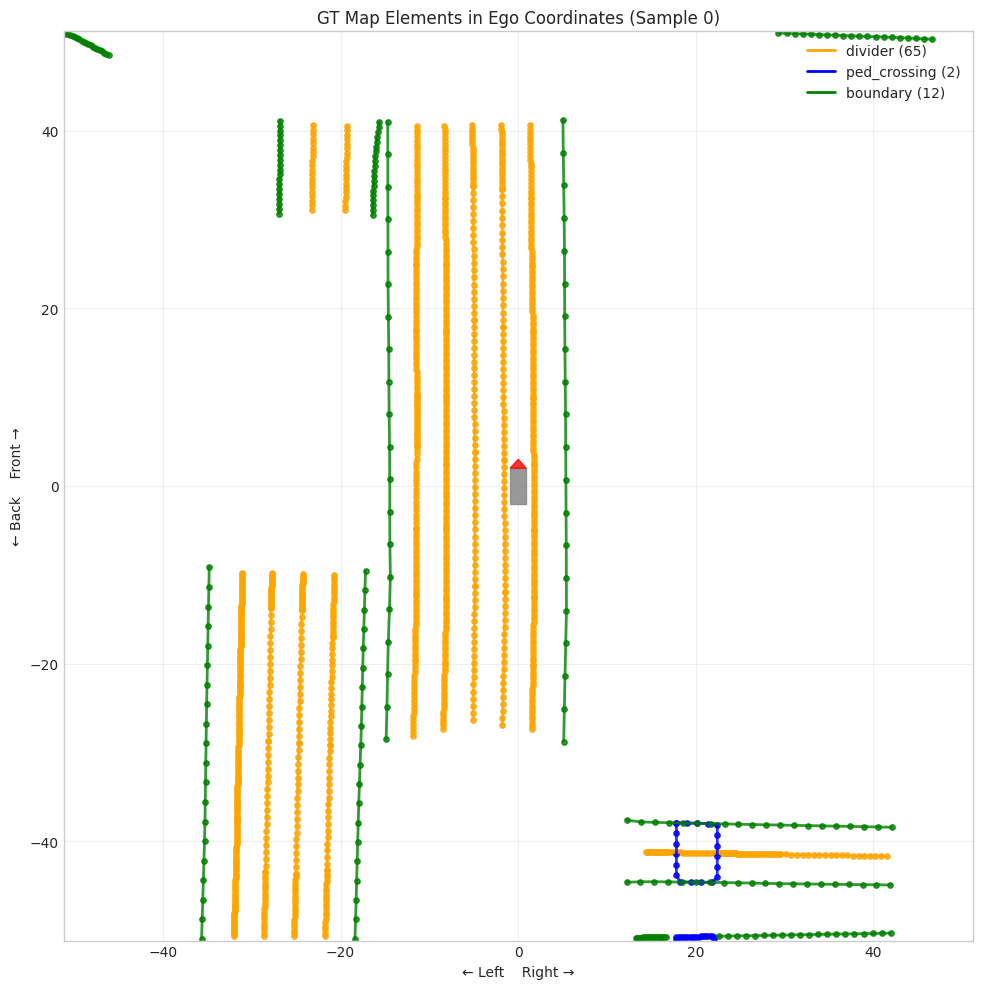


Total elements: 79
  divider: 65
  ped_crossing: 2
  boundary: 12


In [17]:
# Ego 좌표계에서 GT map elements 시각화
import torch

gt_bboxes_3d = data['gt_bboxes_3d'].data
gt_labels_3d = data['gt_labels_3d'].data

# pc_range 가져오기
pc_range = cfg.point_cloud_range  # [x_min, y_min, z_min, x_max, y_max, z_max]
print(f"PC Range: {pc_range}")

# 클래스 이름 및 색상
class_names = ['divider', 'ped_crossing', 'boundary']
COLORS_PLT = ['orange', 'blue', 'green']

fig, ax = plt.subplots(figsize=(10, 10))

# 시각화 범위 설정: X(전방)가 위, Y(왼쪽)가 왼쪽
# plot 좌표: plot_x = -ego_y, plot_y = ego_x
ax.set_xlim(-pc_range[4], -pc_range[1])  # -Y range
ax.set_ylim(pc_range[0], pc_range[3])    # X range
ax.set_aspect('equal')

num_elements = {'divider': 0, 'ped_crossing': 0, 'boundary': 0}

# fixed_num_sampled_points 사용
if hasattr(gt_bboxes_3d, 'fixed_num_sampled_points'):
    gt_lines = gt_bboxes_3d.fixed_num_sampled_points
    
    for gt_pts, gt_label in zip(gt_lines, gt_labels_3d):
        if isinstance(gt_pts, torch.Tensor):
            pts = gt_pts.numpy()
        else:
            pts = gt_pts
        
        label_idx = int(gt_label)
        if label_idx < 0 or label_idx >= len(class_names):
            continue
        
        ego_x = pts[:, 0]  # forward
        ego_y = pts[:, 1]  # left
        
        # Skip padding values
        valid_mask = (ego_x > -9000) & (ego_y > -9000)
        if not valid_mask.any():
            continue
        
        ego_x = ego_x[valid_mask]
        ego_y = ego_y[valid_mask]
        
        # Transform: plot_x = -ego_y, plot_y = ego_x
        plot_x = -ego_y
        plot_y = ego_x
        
        ax.plot(plot_x, plot_y, color=COLORS_PLT[label_idx], linewidth=2, alpha=0.8)
        ax.scatter(plot_x, plot_y, color=COLORS_PLT[label_idx], s=15, alpha=0.8)
        
        num_elements[class_names[label_idx]] += 1

# 차량 표시 (ego 위치)
car_body = plt.Rectangle((-0.9, -2.0), 1.8, 4.0, color='gray', alpha=0.8, zorder=10)
car_front = plt.Polygon([[-0.9, 2.0], [0.9, 2.0], [0, 3.0]], color='red', alpha=0.8, zorder=11)
ax.add_patch(car_body)
ax.add_patch(car_front)

# Legend
legend_elements = [
    plt.Line2D([0], [0], color='orange', lw=2, label=f'divider ({num_elements["divider"]})'),
    plt.Line2D([0], [0], color='blue', lw=2, label=f'ped_crossing ({num_elements["ped_crossing"]})'),
    plt.Line2D([0], [0], color='green', lw=2, label=f'boundary ({num_elements["boundary"]})')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_xlabel('← Left    Right →', fontsize=10)
ax.set_ylabel('← Back    Front →', fontsize=10)
ax.set_title(f'GT Map Elements in Ego Coordinates (Sample {sample_idx})', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal elements: {sum(num_elements.values())}")
for name, count in num_elements.items():
    print(f"  {name}: {count}")

## 10. NavSim 맵의 모든 레이어 시각화

In [18]:
# NavSim GPKG 맵의 모든 레이어 확인
print("=== all_layers에 로드된 모든 레이어 ===")
for name, gdf in all_layers.items():
    if gdf is not None and len(gdf) > 0:
        geom_types = gdf.geom_type.unique().tolist() if 'geometry' in gdf.columns else ['No geometry']
        print(f"{name}: {len(gdf)} records, geometry: {geom_types}")

=== all_layers에 로드된 모든 레이어 ===
baseline_paths: 4583 records, geometry: ['LineString']
carpark_areas: 71 records, geometry: ['Polygon']
generic_drivable_areas: 128 records, geometry: ['Polygon']
dubins_nodes: 5444 records, geometry: ['Point']
lane_connectors: 2544 records, geometry: ['LineString']
intersections: 522 records, geometry: ['Polygon']
boundaries: 12092 records, geometry: ['LineString']
crosswalks: 233 records, geometry: ['Polygon']
lanes_polygons: 2039 records, geometry: ['Polygon']
lane_group_connectors: 1076 records, geometry: ['Polygon']
lane_groups_polygons: 807 records, geometry: ['Polygon']
road_segments: 662 records, geometry: ['Polygon']
stop_polygons: 567 records, geometry: ['Polygon']
traffic_lights: 597 records, geometry: ['Point']
walkways: 276 records, geometry: ['Polygon']
meta: 3 records, geometry: ['No geometry']
gen_lane_connectors_scaled_width_polygons: 2544 records, geometry: ['Polygon']


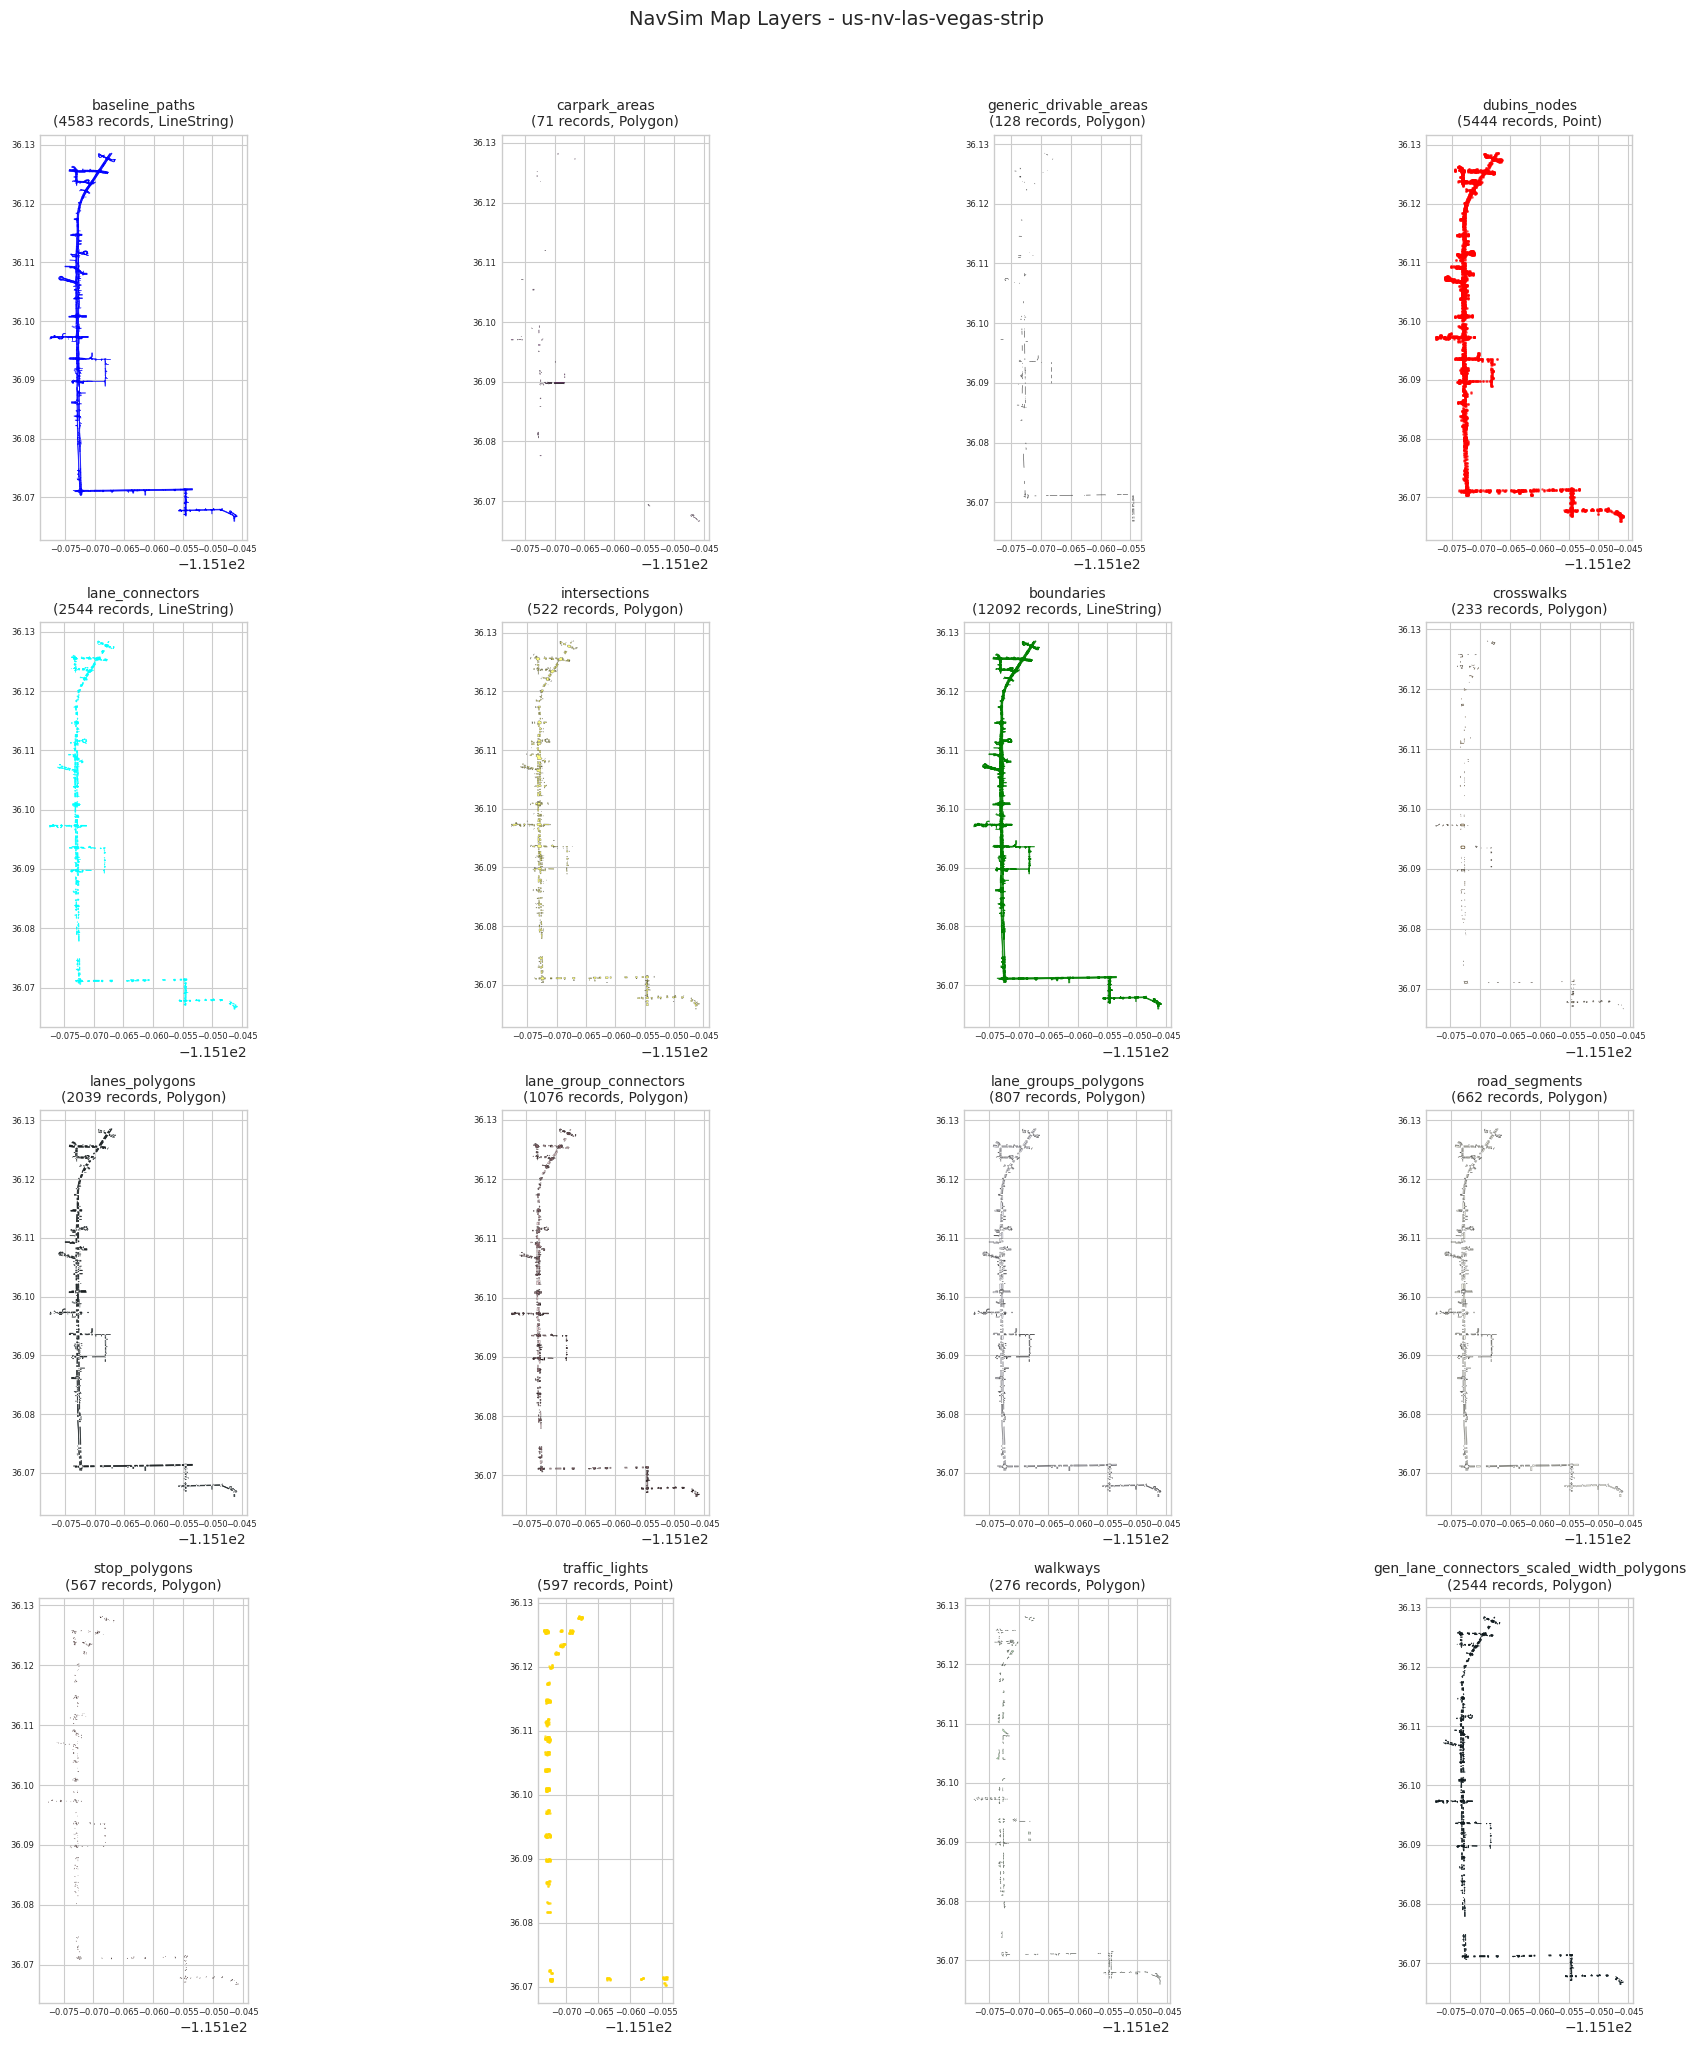


총 16개 레이어 시각화 완료


In [19]:
# 모든 레이어 개별 시각화
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

# geometry가 있는 레이어만 필터링
geo_layers = {name: gdf for name, gdf in all_layers.items() 
              if 'geometry' in gdf.columns and len(gdf) > 0 and gdf.geom_type.iloc[0] != None}

n_layers = len(geo_layers)
cols = 4
rows = (n_layers + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

# 각 레이어별 색상 정의
layer_colors = {
    'baseline_paths': 'blue',
    'carpark_areas': 'purple',
    'generic_drivable_areas': 'lightgray',
    'dubins_nodes': 'red',
    'lane_connectors': 'cyan',
    'intersections': 'yellow',
    'boundaries': 'green',
    'crosswalks': 'orange',
    'lanes_polygons': 'lightblue',
    'lane_group_connectors': 'pink',
    'lane_groups_polygons': 'lavender',
    'road_segments': 'beige',
    'stop_polygons': 'red',
    'traffic_lights': 'gold',
    'walkways': 'lightgreen',
    'gen_lane_connectors_scaled_width_polygons': 'skyblue'
}

for idx, (layer_name, gdf) in enumerate(geo_layers.items()):
    ax = axes[idx]
    
    geom_type = gdf.geom_type.iloc[0]
    color = layer_colors.get(layer_name, 'gray')
    
    try:
        if geom_type == 'Point':
            # Point geometry
            x = [geom.x for geom in gdf.geometry]
            y = [geom.y for geom in gdf.geometry]
            ax.scatter(x, y, c=color, s=1, alpha=0.5)
        elif geom_type == 'LineString':
            # LineString geometry
            for geom in gdf.geometry:
                if geom is not None:
                    x, y = geom.xy
                    ax.plot(x, y, color=color, linewidth=0.5, alpha=0.7)
        elif geom_type in ['Polygon', 'MultiPolygon']:
            # Polygon geometry
            gdf.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, alpha=0.5)
        else:
            # 기타
            gdf.plot(ax=ax, color=color, alpha=0.5)
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:30]}', transform=ax.transAxes, ha='center')
    
    ax.set_title(f'{layer_name}\n({len(gdf)} records, {geom_type})', fontsize=10)
    ax.set_aspect('equal')
    ax.tick_params(labelsize=6)

# 빈 subplot 숨기기
for idx in range(len(geo_layers), len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'NavSim Map Layers - {location}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n총 {len(geo_layers)}개 레이어 시각화 완료")

## 11. Ego 좌표계 기준 특정 영역에서 모든 레이어 개별 시각화

In [32]:
# Ego 좌표계 기준 특정 영역에서 모든 레이어 개별 시각화
sample_idx = 0
data = dataset[sample_idx]

# img_metas 접근
img_metas = data['img_metas'].data[0]
sample_token = img_metas.get('sample_idx')
scene_token = img_metas.get('scene_token')
print("Sample token:", sample_token)
print("Scene token:", scene_token)

# PKL 파일에서 원본 정보 확인
import pickle
from scipy.spatial.transform import Rotation as R

pkl_path = '/home/byounggun/MapTR/data/navsim/navsim_map_infos_test.pkl'
with open(pkl_path, 'rb') as f:
    pkl_data = pickle.load(f)

# samples 리스트에서 해당 샘플 찾기
samples = pkl_data['samples']
sample_info = None
for s in samples:
    if s.get('token') == sample_token or s.get('sample_idx') == sample_token:
        sample_info = s
        break

if sample_info:
    print(f"\n=== Sample Info ===")
    print(f"Map location: {sample_info['map_location']}")
    ego_trans = sample_info['ego2global_translation']
    ego_rot = sample_info['ego2global_rotation']  # quaternion [w, x, y, z] or [x, y, z, w]
    print(f"ego2global_translation: {ego_trans}")
    print(f"ego2global_rotation: {ego_rot}")
    
    # Quaternion to rotation matrix (scipy uses [x, y, z, w] format)
    # NavSim/NuPlan uses [w, x, y, z] format
    quat_xyzw = [ego_rot[1], ego_rot[2], ego_rot[3], ego_rot[0]]  # convert to scipy format
    rot = R.from_quat(quat_xyzw)
    ego_heading = rot.as_euler('zxy')[0]  # yaw angle
    print(f"Ego heading: {np.degrees(ego_heading):.2f} degrees")
    
    ego_x_global = ego_trans[0]
    ego_y_global = ego_trans[1]
    print(f"Ego position (global): x={ego_x_global:.2f}, y={ego_y_global:.2f}")
    
    # 해당 location의 맵 로드
    sample_location = sample_info['map_location']
    sample_map_path = os.path.join(map_root, sample_location, map_info.get(sample_location, ''), 'map.gpkg')
    print(f"\nMap path: {sample_map_path}")
    print(f"Exists: {os.path.exists(sample_map_path)}")
else:
    print("Sample not found in pkl!")
    # 대신 첫 번째 샘플 사용
    sample_info = samples[0]
    print(f"\nUsing first sample instead:")
    print(f"Map location: {sample_info['map_location']}")
    ego_trans = sample_info['ego2global_translation']
    ego_rot = sample_info['ego2global_rotation']
    
    quat_xyzw = [ego_rot[1], ego_rot[2], ego_rot[3], ego_rot[0]]
    rot = R.from_quat(quat_xyzw)
    ego_heading = rot.as_euler('zxy')[0]
    
    ego_x_global = ego_trans[0]
    ego_y_global = ego_trans[1]
    print(f"Ego position (global): x={ego_x_global:.2f}, y={ego_y_global:.2f}")
    
    sample_location = sample_info['map_location']
    sample_map_path = os.path.join(map_root, sample_location, map_info.get(sample_location, ''), 'map.gpkg')

Sample token: 95c09c7857035d5e
Scene token: 2021.05.25.14.16.10_veh-35_00083_00485

=== Sample Info ===
Map location: us-nv-las-vegas-strip
ego2global_translation: [6.64458705e+05 3.99814719e+06 6.14947887e+02]
ego2global_rotation: [0.7053508  0.00931259 0.00929897 0.70873623]
Ego heading: 90.27 degrees
Ego position (global): x=664458.71, y=3998147.19

Map path: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True

=== Sample Info ===
Map location: us-nv-las-vegas-strip
ego2global_translation: [6.64458705e+05 3.99814719e+06 6.14947887e+02]
ego2global_rotation: [0.7053508  0.00931259 0.00929897 0.70873623]
Ego heading: 90.27 degrees
Ego position (global): x=664458.71, y=3998147.19

Map path: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True


=== 좌표계 변환 및 Ego 뷰 시각화 ===
Converted 16 layers to UTM

Boundaries bounds (UTM): x=[664048, 666987], y=[3992852, 3999768]
Ego position (UTM): x=664458.71, y=3998147.19
Ego in X range: True, Ego in Y range: True

View box bounds (UTM): (664407.2608970784, 3998095.7499834993, 664510.1499679355, 3998198.6390543566)


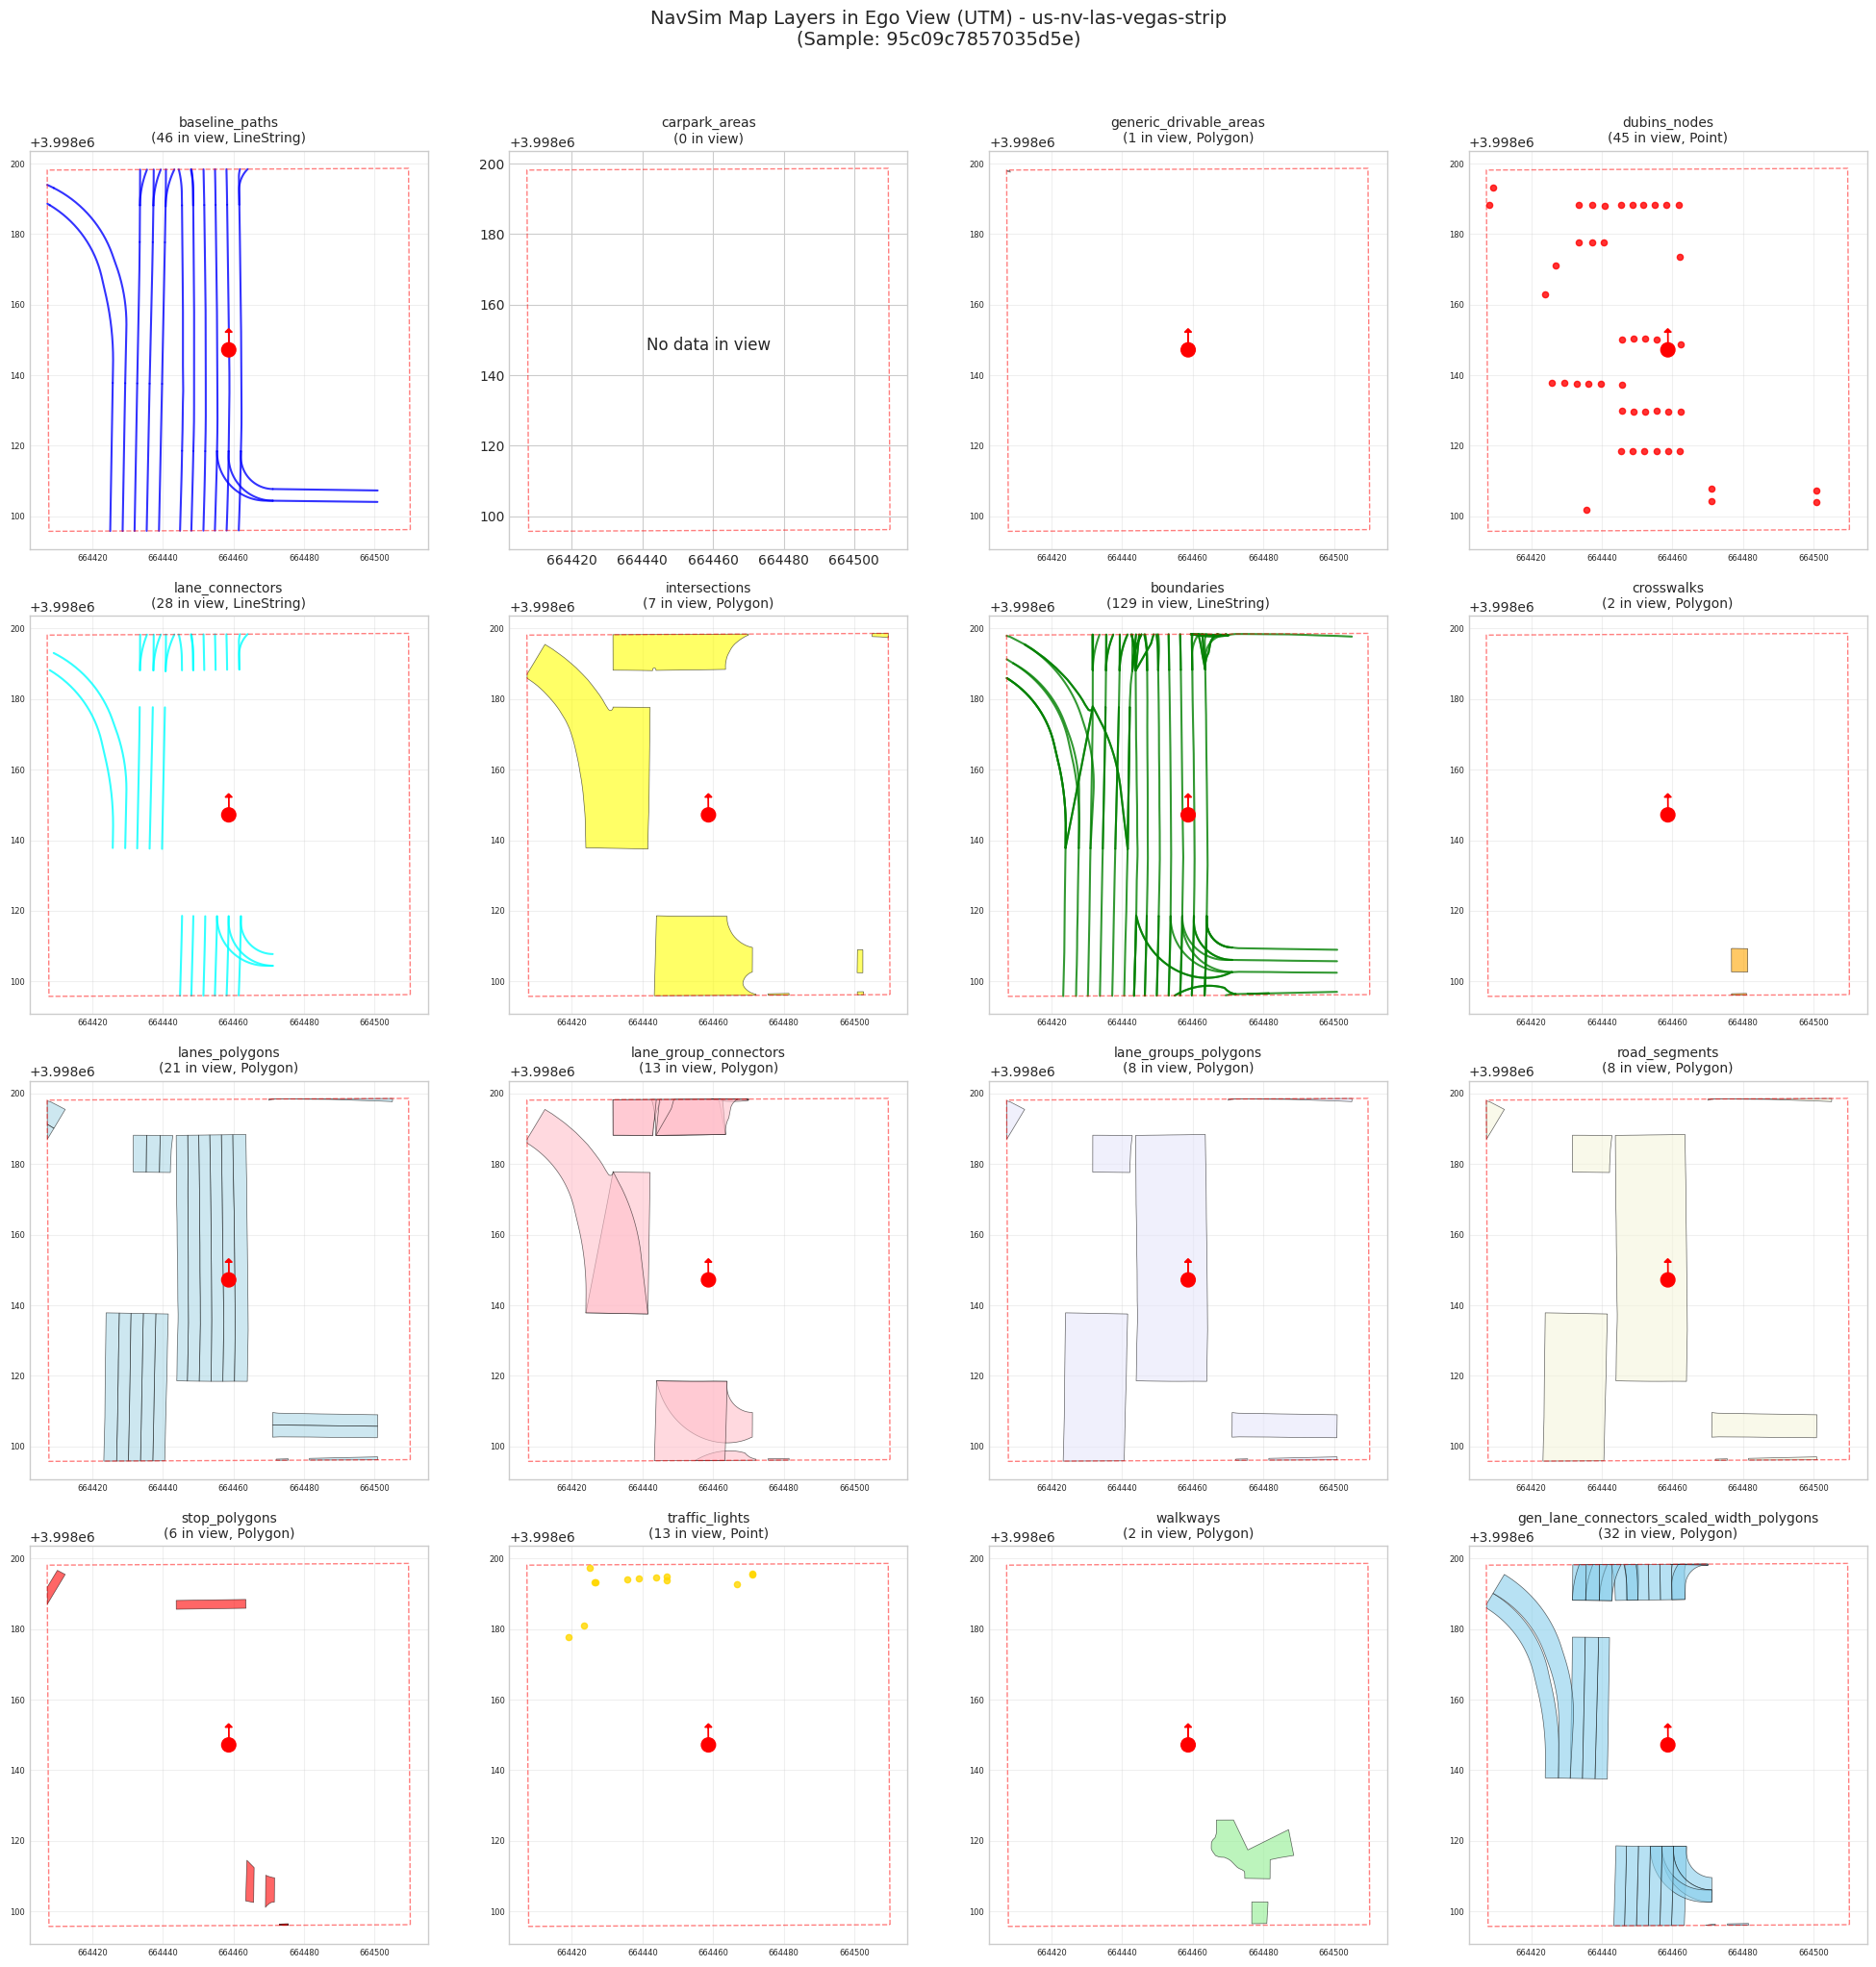


총 16개 벡터 레이어를 Ego 뷰 영역에서 시각화


In [36]:
# 좌표계 변환 후 Ego 뷰 시각화
# 맵 데이터(WGS84)를 UTM으로 변환하여 Ego 좌표와 맞춤
from pyproj import Transformer

print("=== 좌표계 변환 및 Ego 뷰 시각화 ===")

# Las Vegas는 UTM Zone 11N (EPSG:32611)
target_crs = "EPSG:32611"

# 맵 레이어들을 UTM으로 변환
sample_layers_utm = {}
for name, gdf in sample_all_layers.items():
    if 'geometry' in gdf.columns and len(gdf) > 0:
        try:
            gdf_utm = gdf.to_crs(target_crs)
            sample_layers_utm[name] = gdf_utm
        except Exception as e:
            print(f"  {name}: 변환 실패 - {e}")

print(f"Converted {len(sample_layers_utm)} layers to UTM")

# 변환된 boundaries bounds 확인
if 'boundaries' in sample_layers_utm:
    bd_utm = sample_layers_utm['boundaries']
    bd_bounds = bd_utm.total_bounds
    print(f"\nBoundaries bounds (UTM): x=[{bd_bounds[0]:.0f}, {bd_bounds[2]:.0f}], y=[{bd_bounds[1]:.0f}, {bd_bounds[3]:.0f}]")
    print(f"Ego position (UTM): x={ego_x_global:.2f}, y={ego_y_global:.2f}")
    
    # Ego가 범위 안에 있는지 확인
    in_x = bd_bounds[0] <= ego_x_global <= bd_bounds[2]
    in_y = bd_bounds[1] <= ego_y_global <= bd_bounds[3]
    print(f"Ego in X range: {in_x}, Ego in Y range: {in_y}")

# View box (UTM 좌표계에서)
print(f"\nView box bounds (UTM): {view_box.bounds}")

# geometry가 있는 레이어만 필터링
geo_layers_utm = {name: gdf for name, gdf in sample_layers_utm.items() 
                  if 'geometry' in gdf.columns and len(gdf) > 0 
                  and gdf.geom_type.iloc[0] is not None
                  and name != 'meta'}

n_layers = len(geo_layers_utm)
cols = 4
rows = (n_layers + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

layer_colors = {
    'baseline_paths': 'blue', 'carpark_areas': 'purple', 'generic_drivable_areas': 'lightgray',
    'dubins_nodes': 'red', 'lane_connectors': 'cyan', 'intersections': 'yellow',
    'boundaries': 'green', 'crosswalks': 'orange', 'lanes_polygons': 'lightblue',
    'lane_group_connectors': 'pink', 'lane_groups_polygons': 'lavender', 'road_segments': 'beige',
    'stop_polygons': 'red', 'traffic_lights': 'gold', 'walkways': 'lightgreen',
    'gen_lane_connectors_scaled_width_polygons': 'skyblue'
}

for idx, (layer_name, gdf) in enumerate(geo_layers_utm.items()):
    ax = axes[idx]
    geom_type = gdf.geom_type.iloc[0]
    color = layer_colors.get(layer_name, 'gray')
    
    try:
        clipped = gdf[gdf.geometry.intersects(view_box)].copy()
        if len(clipped) == 0:
            ax.text(0.5, 0.5, 'No data in view', transform=ax.transAxes, ha='center', fontsize=12)
            ax.set_title(f'{layer_name}\n(0 in view)', fontsize=10)
            ax.set_aspect('equal')
            # View box는 표시
            vb_x, vb_y = view_box.exterior.xy
            ax.plot(vb_x, vb_y, 'r--', linewidth=1, alpha=0.5)
            ax.set_xlim(view_box.bounds[0] - 5, view_box.bounds[2] + 5)
            ax.set_ylim(view_box.bounds[1] - 5, view_box.bounds[3] + 5)
            continue
        
        clipped['geometry'] = clipped.geometry.intersection(view_box)
        clipped = clipped[~clipped.geometry.is_empty]
        
        if geom_type == 'Point':
            x = [geom.x for geom in clipped.geometry if geom is not None and not geom.is_empty]
            y = [geom.y for geom in clipped.geometry if geom is not None and not geom.is_empty]
            ax.scatter(x, y, c=color, s=20, alpha=0.8, zorder=5)
        elif geom_type == 'LineString':
            for geom in clipped.geometry:
                if geom is not None and not geom.is_empty:
                    if geom.geom_type == 'LineString':
                        x, y = geom.xy
                        ax.plot(x, y, color=color, linewidth=1.5, alpha=0.8)
                    elif geom.geom_type == 'MultiLineString':
                        for line in geom.geoms:
                            x, y = line.xy
                            ax.plot(x, y, color=color, linewidth=1.5, alpha=0.8)
        elif geom_type in ['Polygon', 'MultiPolygon']:
            clipped.plot(ax=ax, color=color, edgecolor='black', linewidth=0.5, alpha=0.6)
        else:
            clipped.plot(ax=ax, color=color, alpha=0.5)
        
        # Ego 차량 표시
        ego_marker = plt.Circle((ego_x_global, ego_y_global), 2, color='red', zorder=10)
        ax.add_patch(ego_marker)
        
        # Heading 화살표
        arrow_len = 5
        ax.arrow(ego_x_global, ego_y_global, arrow_len * cos_h, arrow_len * sin_h,
                 head_width=2, head_length=1, fc='red', ec='red', zorder=11)
        
        ax.set_title(f'{layer_name}\n({len(clipped)} in view, {geom_type})', fontsize=10)
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:40]}', transform=ax.transAxes, ha='center', fontsize=8)
        ax.set_title(f'{layer_name}\n(Error)', fontsize=10)
    
    # View box 경계 표시
    vb_x, vb_y = view_box.exterior.xy
    ax.plot(vb_x, vb_y, 'r--', linewidth=1, alpha=0.5)
    
    ax.set_xlim(view_box.bounds[0] - 5, view_box.bounds[2] + 5)
    ax.set_ylim(view_box.bounds[1] - 5, view_box.bounds[3] + 5)
    ax.set_aspect('equal')
    ax.tick_params(labelsize=6)
    ax.grid(True, alpha=0.3)

for idx in range(len(geo_layers_utm), len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'NavSim Map Layers in Ego View (UTM) - {sample_location}\n(Sample: {sample_token})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n총 {len(geo_layers_utm)}개 벡터 레이어를 Ego 뷰 영역에서 시각화")

=== 레이어별 하위 타입 분석 ===

boundaries (boundary_type_fid):
  0: 1232 records
  2: 1469 records
  3: 9391 records



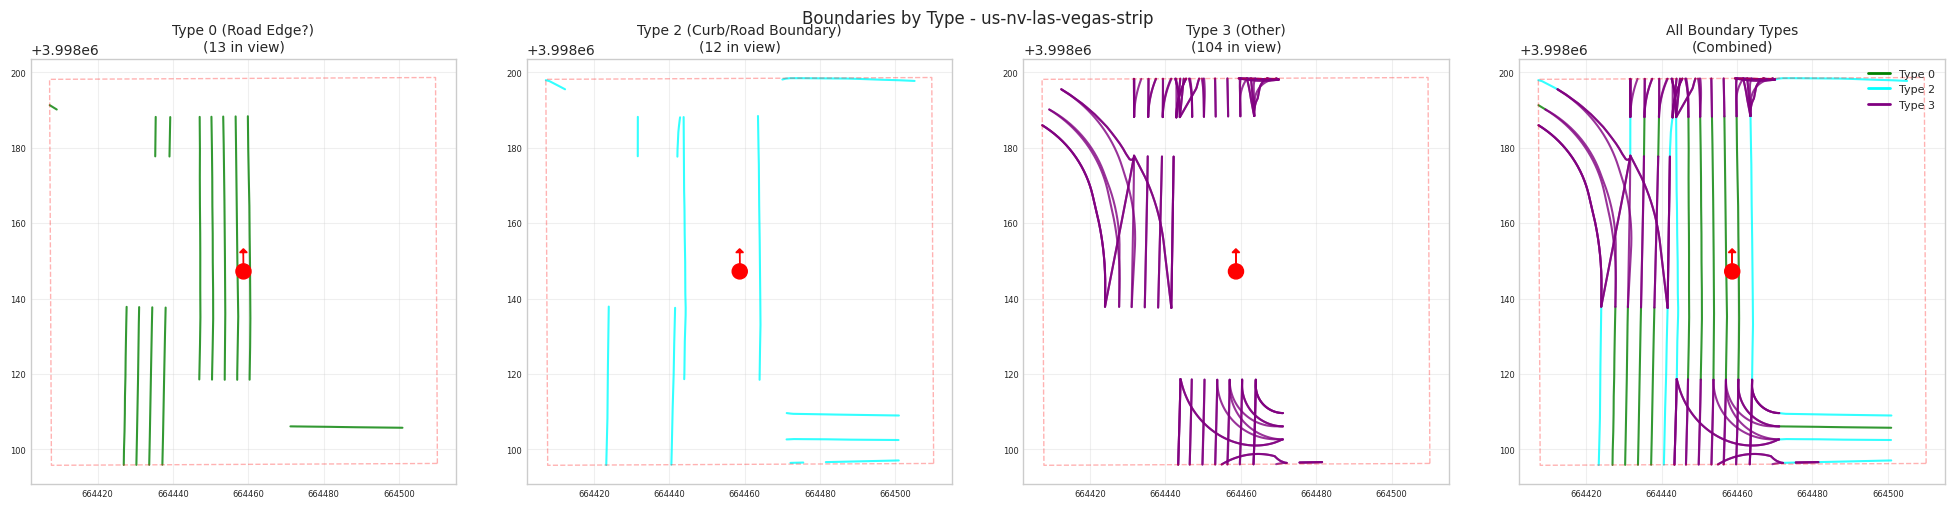


=== 시각화 완료 ===


In [37]:
# 레이어 내 세부 타입별 시각화
# boundaries, lanes_polygons, road_segments 등의 하위 타입 확인 및 시각화

print("=== 레이어별 하위 타입 분석 ===\n")

# 분석할 레이어들과 타입 컬럼
type_columns = {
    'boundaries': 'boundary_type_fid',
    'road_segments': 'road_type_fid',
    'lanes_polygons': 'lane_type',  # 있을 수 있음
    'lane_connectors': 'lane_type',
    'intersections': 'intersection_type',
}

# 각 레이어의 하위 타입 분석
layer_subtypes = {}
for layer_name, type_col in type_columns.items():
    if layer_name in sample_layers_utm:
        gdf = sample_layers_utm[layer_name]
        if type_col in gdf.columns:
            unique_vals = sorted(gdf[type_col].unique())
            counts = gdf[type_col].value_counts().to_dict()
            layer_subtypes[layer_name] = {
                'column': type_col,
                'values': unique_vals,
                'counts': counts
            }
            print(f"{layer_name} ({type_col}):")
            for val in unique_vals:
                print(f"  {val}: {counts.get(val, 0)} records")
            print()

# Boundaries 세부 시각화
if 'boundaries' in sample_layers_utm and 'boundary_type_fid' in sample_layers_utm['boundaries'].columns:
    bd_gdf = sample_layers_utm['boundaries']
    bd_types = sorted(bd_gdf['boundary_type_fid'].unique())
    
    # 타입별 색상
    bd_type_colors = {0: 'green', 2: 'cyan', 3: 'purple'}
    bd_type_names = {0: 'Type 0 (Road Edge?)', 2: 'Type 2 (Curb/Road Boundary)', 3: 'Type 3 (Other)'}
    
    n_types = len(bd_types)
    fig, axes = plt.subplots(1, n_types + 1, figsize=(5 * (n_types + 1), 5))
    
    # 각 타입별 시각화
    for idx, bd_type in enumerate(bd_types):
        ax = axes[idx]
        type_gdf = bd_gdf[bd_gdf['boundary_type_fid'] == bd_type]
        clipped = type_gdf[type_gdf.geometry.intersects(view_box)].copy()
        
        if len(clipped) > 0:
            clipped['geometry'] = clipped.geometry.intersection(view_box)
            clipped = clipped[~clipped.geometry.is_empty]
            
            for geom in clipped.geometry:
                if geom is not None and not geom.is_empty:
                    if geom.geom_type == 'LineString':
                        x, y = geom.xy
                        ax.plot(x, y, color=bd_type_colors.get(bd_type, 'gray'), linewidth=1.5, alpha=0.8)
                    elif geom.geom_type == 'MultiLineString':
                        for line in geom.geoms:
                            x, y = line.xy
                            ax.plot(x, y, color=bd_type_colors.get(bd_type, 'gray'), linewidth=1.5, alpha=0.8)
        
        # Ego 표시
        ego_marker = plt.Circle((ego_x_global, ego_y_global), 2, color='red', zorder=10)
        ax.add_patch(ego_marker)
        ax.arrow(ego_x_global, ego_y_global, arrow_len * cos_h, arrow_len * sin_h,
                 head_width=2, head_length=1, fc='red', ec='red', zorder=11)
        
        # View box
        vb_x, vb_y = view_box.exterior.xy
        ax.plot(vb_x, vb_y, 'r--', linewidth=1, alpha=0.3)
        
        ax.set_xlim(view_box.bounds[0] - 5, view_box.bounds[2] + 5)
        ax.set_ylim(view_box.bounds[1] - 5, view_box.bounds[3] + 5)
        ax.set_aspect('equal')
        ax.set_title(f'{bd_type_names.get(bd_type, f"Type {bd_type}")}\n({len(clipped)} in view)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=6)
    
    # 전체 합쳐서 보기
    ax = axes[-1]
    for bd_type in bd_types:
        type_gdf = bd_gdf[bd_gdf['boundary_type_fid'] == bd_type]
        clipped = type_gdf[type_gdf.geometry.intersects(view_box)].copy()
        
        if len(clipped) > 0:
            clipped['geometry'] = clipped.geometry.intersection(view_box)
            clipped = clipped[~clipped.geometry.is_empty]
            
            for geom in clipped.geometry:
                if geom is not None and not geom.is_empty:
                    if geom.geom_type == 'LineString':
                        x, y = geom.xy
                        ax.plot(x, y, color=bd_type_colors.get(bd_type, 'gray'), linewidth=1.5, alpha=0.8,
                               label=f'Type {bd_type}' if bd_type == bd_types[0] or geom == clipped.geometry.iloc[0] else '')
                    elif geom.geom_type == 'MultiLineString':
                        for line in geom.geoms:
                            x, y = line.xy
                            ax.plot(x, y, color=bd_type_colors.get(bd_type, 'gray'), linewidth=1.5, alpha=0.8)
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=bd_type_colors.get(t, 'gray'), lw=2, 
                                   label=f'Type {t}') for t in bd_types]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    ego_marker = plt.Circle((ego_x_global, ego_y_global), 2, color='red', zorder=10)
    ax.add_patch(ego_marker)
    ax.arrow(ego_x_global, ego_y_global, arrow_len * cos_h, arrow_len * sin_h,
             head_width=2, head_length=1, fc='red', ec='red', zorder=11)
    
    vb_x, vb_y = view_box.exterior.xy
    ax.plot(vb_x, vb_y, 'r--', linewidth=1, alpha=0.3)
    
    ax.set_xlim(view_box.bounds[0] - 5, view_box.bounds[2] + 5)
    ax.set_ylim(view_box.bounds[1] - 5, view_box.bounds[3] + 5)
    ax.set_aspect('equal')
    ax.set_title('All Boundary Types\n(Combined)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=6)
    
    plt.suptitle(f'Boundaries by Type - {sample_location}', fontsize=12)
    plt.tight_layout()
    plt.show()

# Road Segments 세부 시각화 (있으면)
if 'road_segments' in sample_layers_utm and 'road_type_fid' in sample_layers_utm['road_segments'].columns:
    rs_gdf = sample_layers_utm['road_segments']
    rs_types = sorted(rs_gdf['road_type_fid'].unique())
    
    print(f"\n=== Road Segments Types ===")
    for t in rs_types:
        print(f"  road_type_fid={t}: {len(rs_gdf[rs_gdf['road_type_fid']==t])} records")
    
    # 색상 팔레트
    import matplotlib.cm as cm
    colors = cm.tab10(np.linspace(0, 1, len(rs_types)))
    rs_type_colors = {t: colors[i] for i, t in enumerate(rs_types)}
    
    n_types = min(len(rs_types), 8)  # 최대 8개만 표시
    fig, axes = plt.subplots(2, (n_types + 2) // 2, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, rs_type in enumerate(rs_types[:n_types]):
        ax = axes[idx]
        type_gdf = rs_gdf[rs_gdf['road_type_fid'] == rs_type]
        clipped = type_gdf[type_gdf.geometry.intersects(view_box)].copy()
        
        if len(clipped) > 0:
            clipped['geometry'] = clipped.geometry.intersection(view_box)
            clipped = clipped[~clipped.geometry.is_empty]
            clipped.plot(ax=ax, color=rs_type_colors[rs_type], edgecolor='black', linewidth=0.3, alpha=0.6)
        
        ego_marker = plt.Circle((ego_x_global, ego_y_global), 2, color='red', zorder=10)
        ax.add_patch(ego_marker)
        
        vb_x, vb_y = view_box.exterior.xy
        ax.plot(vb_x, vb_y, 'r--', linewidth=1, alpha=0.3)
        
        ax.set_xlim(view_box.bounds[0] - 5, view_box.bounds[2] + 5)
        ax.set_ylim(view_box.bounds[1] - 5, view_box.bounds[3] + 5)
        ax.set_aspect('equal')
        ax.set_title(f'road_type_fid={rs_type}\n({len(clipped)} in view)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=6)
    
    # 빈 subplot 숨기기
    for idx in range(n_types, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Road Segments by Type - {sample_location}', fontsize=12)
    plt.tight_layout()
    plt.show()

print("\n=== 시각화 완료 ===")

In [39]:
# 모든 레이어에서 실제 의미있는 카테고리/타입 컬럼만 찾기
# FK 참조 컬럼은 제외하고, unique 값이 2~20개인 진짜 타입 컬럼만

print("=== 레이어별 타입/카테고리 컬럼 (의미있는 것만) ===\n")

# 타입 컬럼 패턴 (strict)
type_patterns = ['_type_fid', 'type_fid', '_type', 'is_']

# FK로 보이는 패턴 (제외할 것)
fk_patterns = ['lane_fid', 'lane_group_fid', 'intersection_fid', 'boundary_fid', 
               'edge_fid', 'connector_fid', 'segment_fid', 'node_fid', 'path_fid',
               'crosswalk_fid', 'traffic_light_fid', 'stop_line_fid', 'area_fid']

meaningful_categories = {}

for layer_name, gdf in sample_layers_utm.items():
    if layer_name == 'meta':
        continue
    
    layer_cats = {}
    for col in gdf.columns:
        col_lower = col.lower()
        
        # FK 컬럼 제외
        if any(fk in col_lower for fk in fk_patterns):
            continue
        # _fids (복수형) 컬럼 제외 (다대다 관계)
        if col_lower.endswith('_fids'):
            continue
        
        # 타입 패턴 또는 unique 값이 2~15개인 숫자/불린 컬럼
        is_type_col = any(pattern in col_lower for pattern in type_patterns)
        
        if is_type_col or col_lower.startswith('is_'):
            unique_vals = sorted(gdf[col].dropna().unique())
            if 2 <= len(unique_vals) <= 20:
                layer_cats[col] = unique_vals
        elif gdf[col].dtype in ['int64', 'int32', 'float64', 'bool']:
            unique_vals = sorted(gdf[col].dropna().unique())
            if 2 <= len(unique_vals) <= 10:  # 더 엄격하게
                # 값이 0,1,2,... 같은 타입 코드인지 확인
                if all(isinstance(v, (int, np.integer)) or (isinstance(v, float) and v.is_integer()) for v in unique_vals):
                    layer_cats[col] = [int(v) if isinstance(v, float) else v for v in unique_vals]
    
    if layer_cats:
        meaningful_categories[layer_name] = layer_cats

# 깔끔하게 출력
print("="*60)
for layer_name, cols in meaningful_categories.items():
    print(f"\n📁 {layer_name}")
    for col, vals in cols.items():
        counts = sample_layers_utm[layer_name][col].value_counts().to_dict()
        print(f"   {col}: {vals}")
        for v in vals:
            print(f"      {v}: {counts.get(v, 0)} records")

print("\n" + "="*60)
print("\n=== 요약: 타입별 시각화 가능한 컬럼들 ===")
for layer_name, cols in meaningful_categories.items():
    for col, vals in cols.items():
        print(f"  {layer_name}.{col} → {len(vals)} types: {vals}")

=== 레이어별 타입/카테고리 컬럼 (의미있는 것만) ===


📁 baseline_paths
   path_type_fid: [0, 1, 2]
      0: 2694 records
      1: 1632 records
      2: 257 records

📁 lane_connectors
   turn_type_fid: [0, 1, 2]
      0: 1420 records
      1: 570 records
      2: 554 records
   reflector_side_fid: [0, 1, 2, 3]
      0: 1072 records
      1: 481 records
      2: 333 records
      3: 658 records

📁 intersections
   intersection_type_fid: [0, 1, 2, 3, 4, 5]
      0: 149 records
      1: 35 records
      2: 43 records
      3: 87 records
      4: 11 records
      5: 197 records
   is_mini: [False, True]
      False: 227 records
      True: 295 records

📁 boundaries
   boundary_type_fid: [0, 2, 3]
      0: 1232 records
      2: 1469 records
      3: 9391 records

📁 crosswalks
   is_marked: [False, True]
      False: 125 records
      True: 108 records

📁 lanes_polygons
   lane_index: [1, 2, 3, 4, 5, 6, 7, 8]
      1: 807 records
      2: 483 records
      3: 332 records
      4: 221 records
      5: 110 recor

=== 모든 카테고리 컬럼 타입별 시각화 ===

📊 baseline_paths.path_type_fid


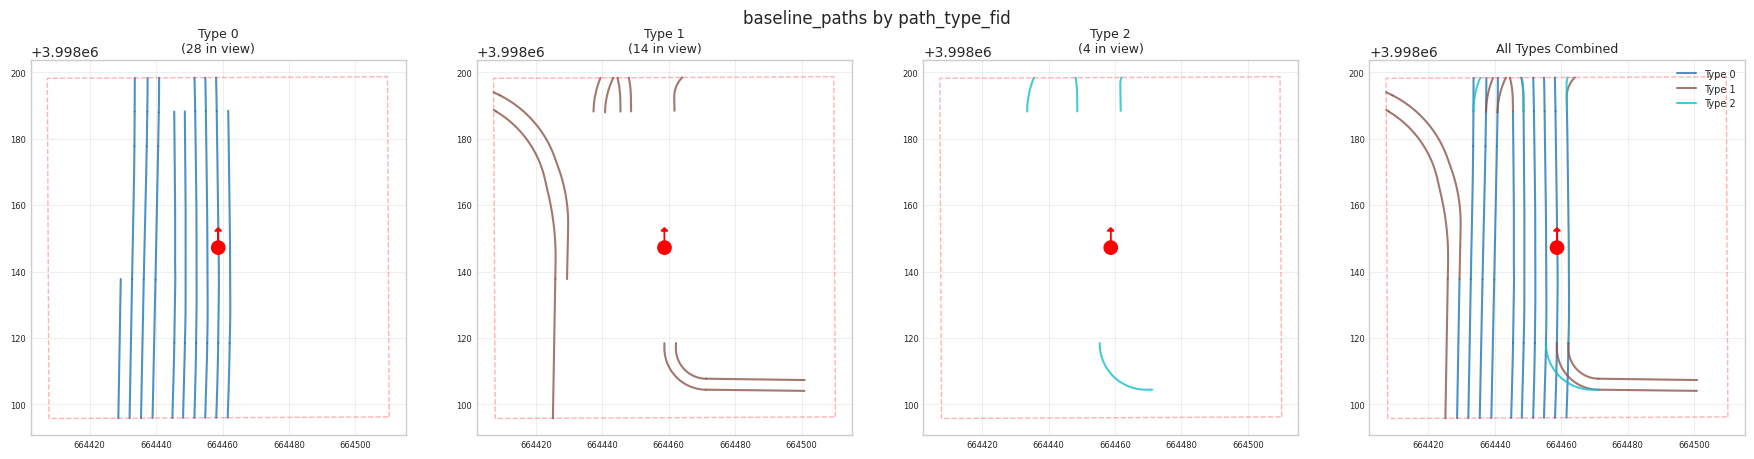


📊 lane_connectors.turn_type_fid


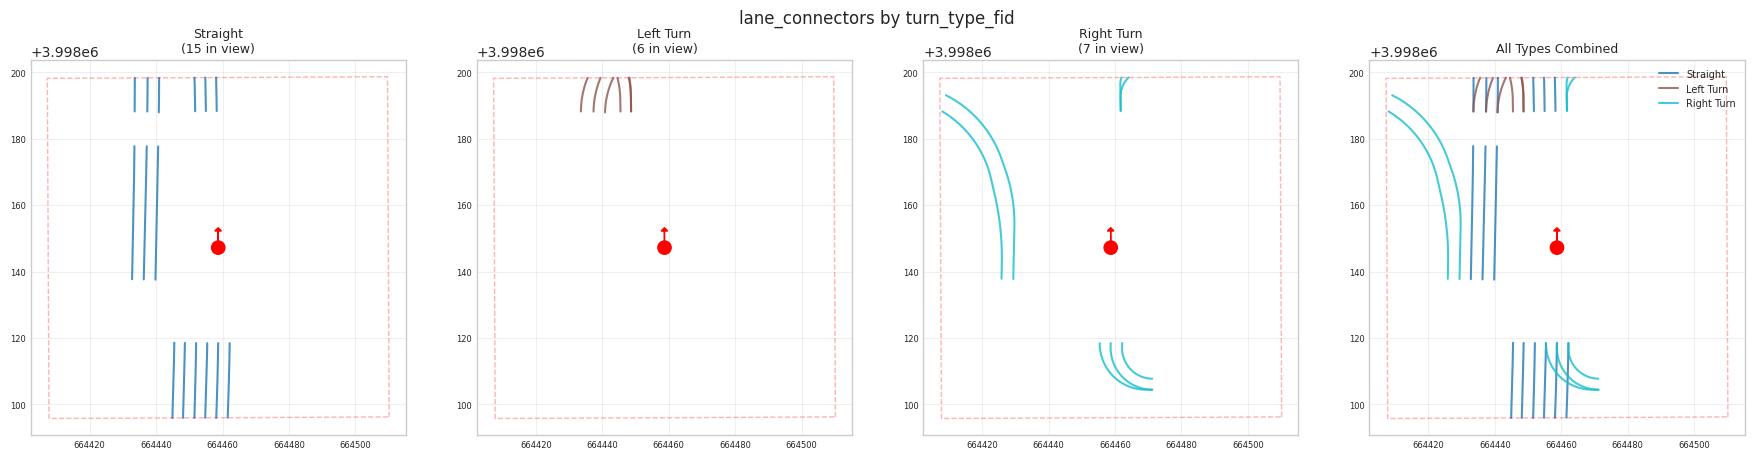


📊 lane_connectors.reflector_side_fid


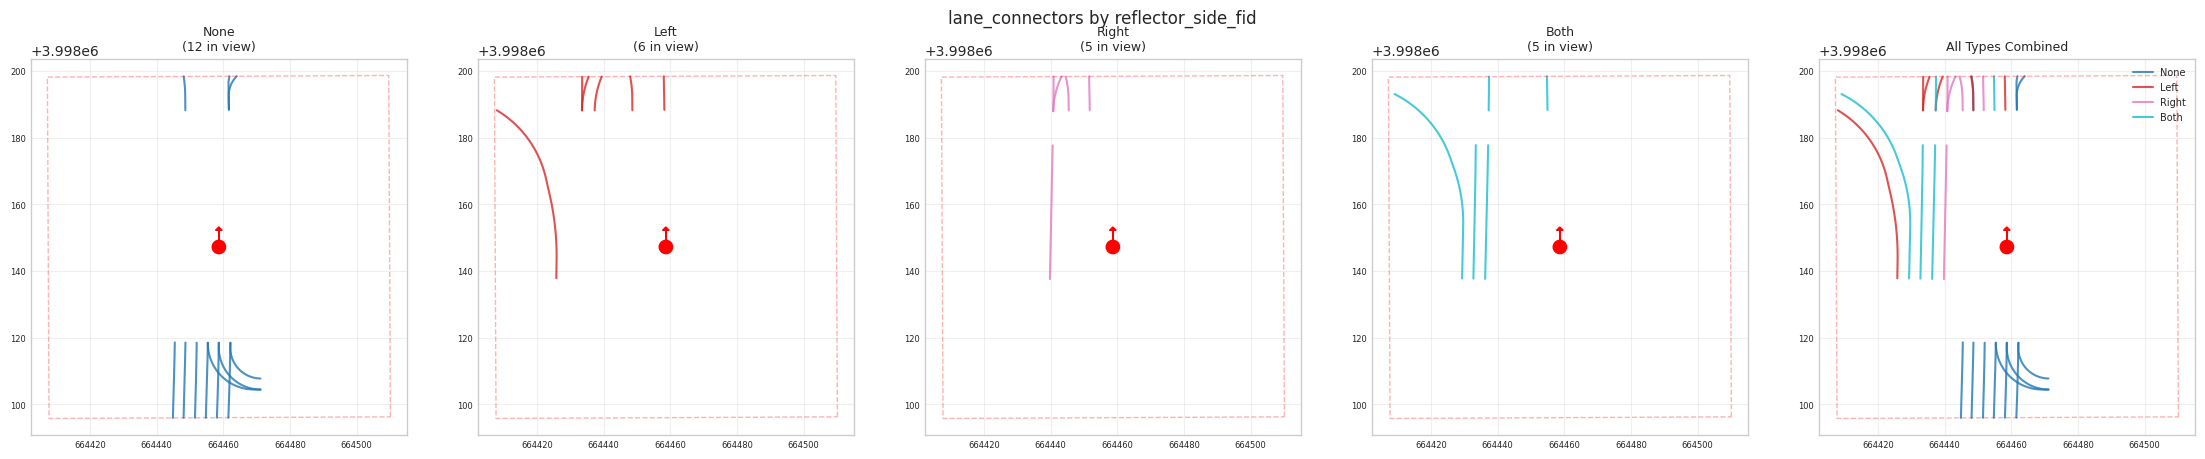


📊 intersections.intersection_type_fid


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


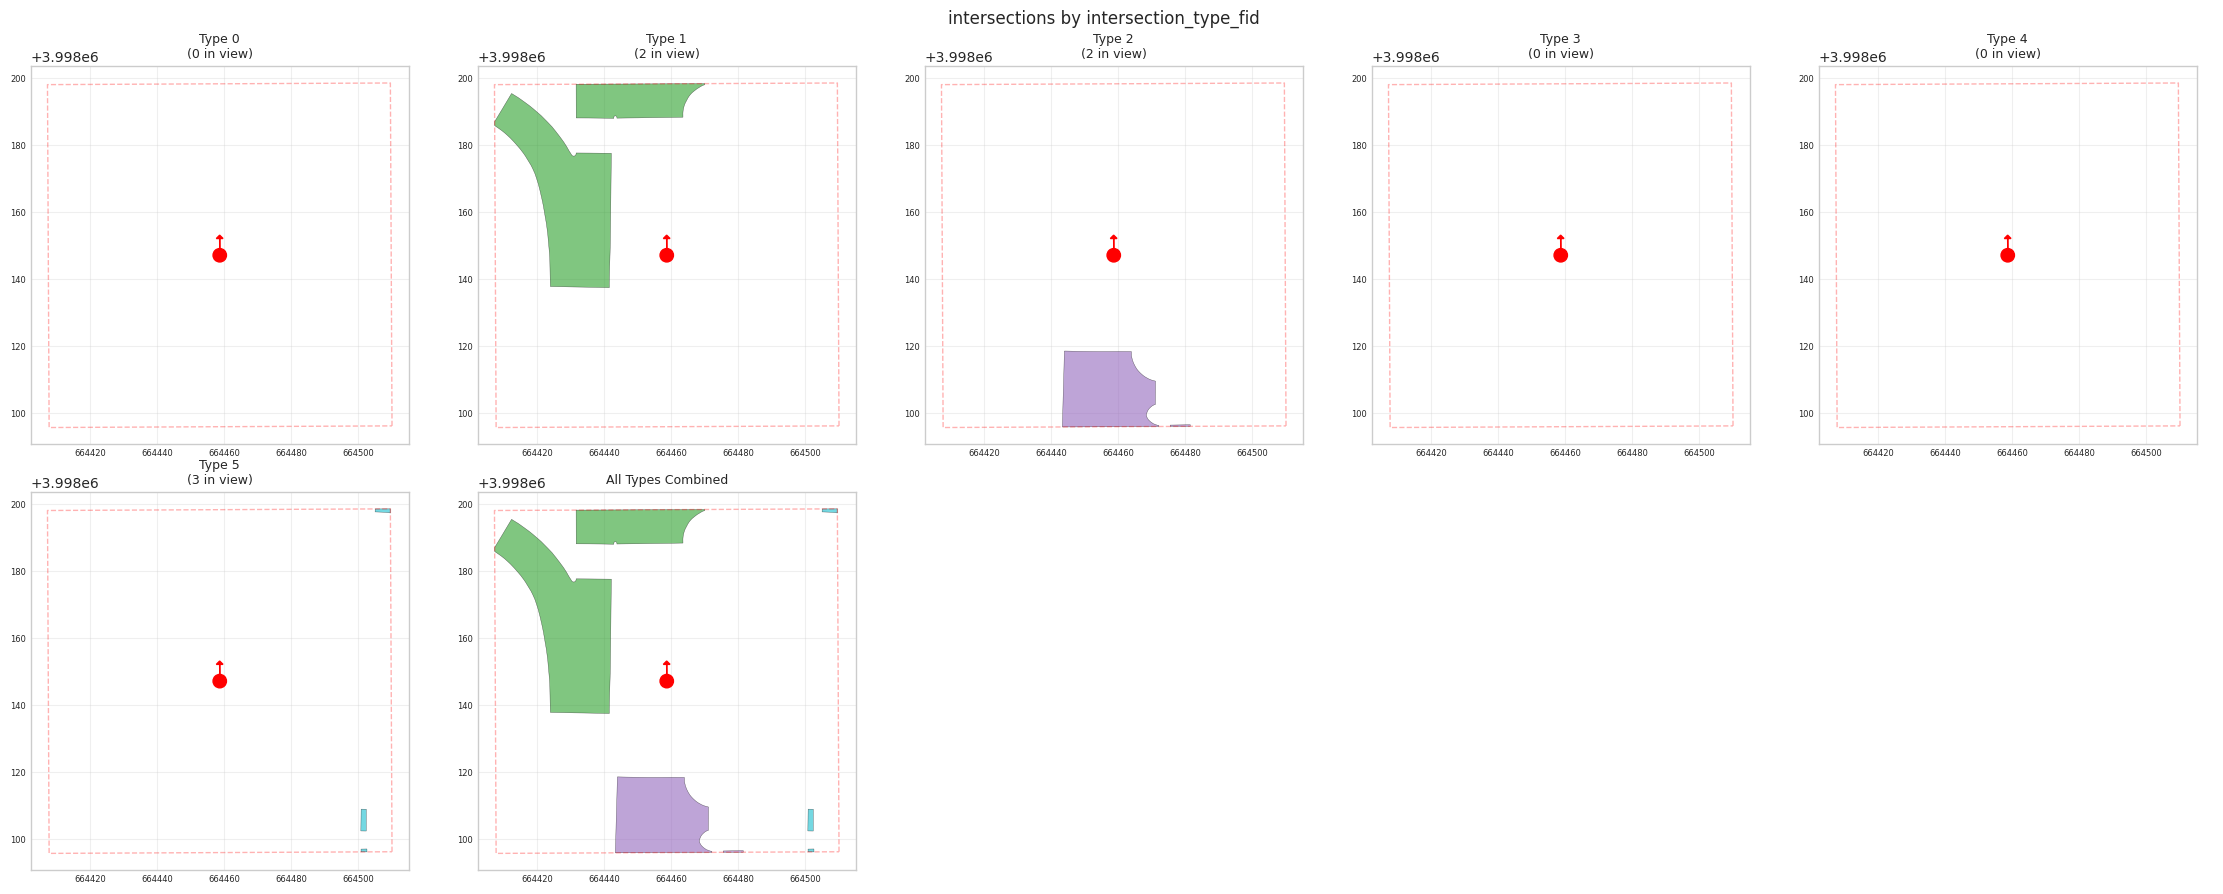


📊 intersections.is_mini


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


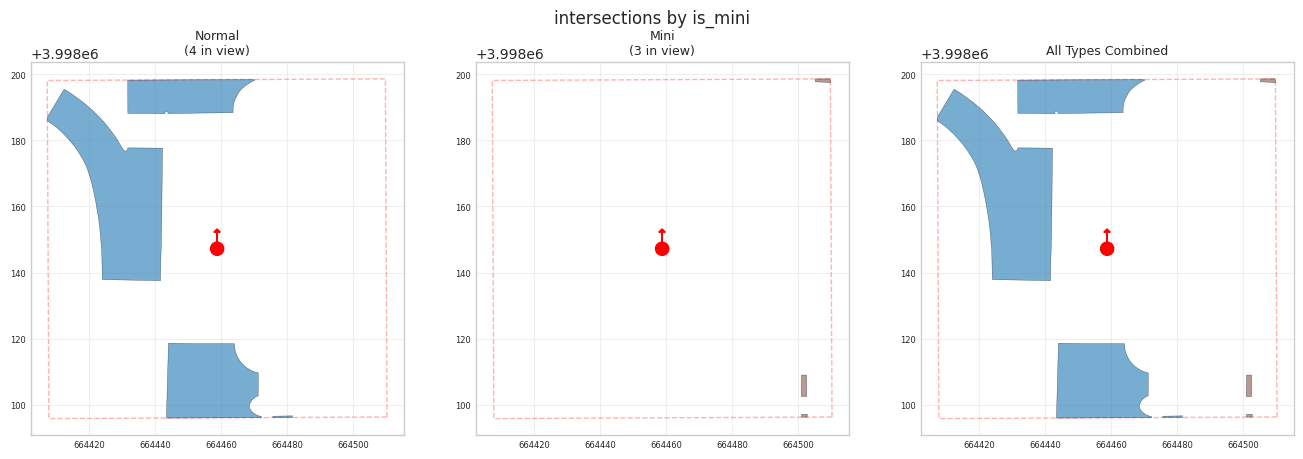


📊 boundaries.boundary_type_fid


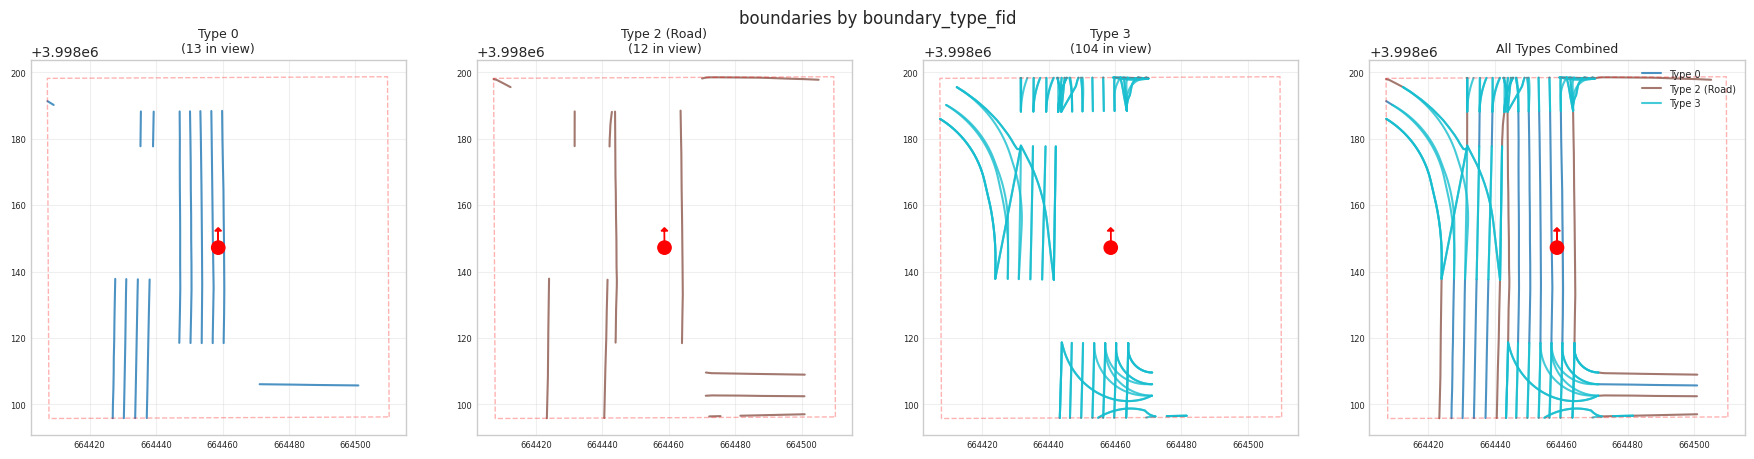


📊 crosswalks.is_marked


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


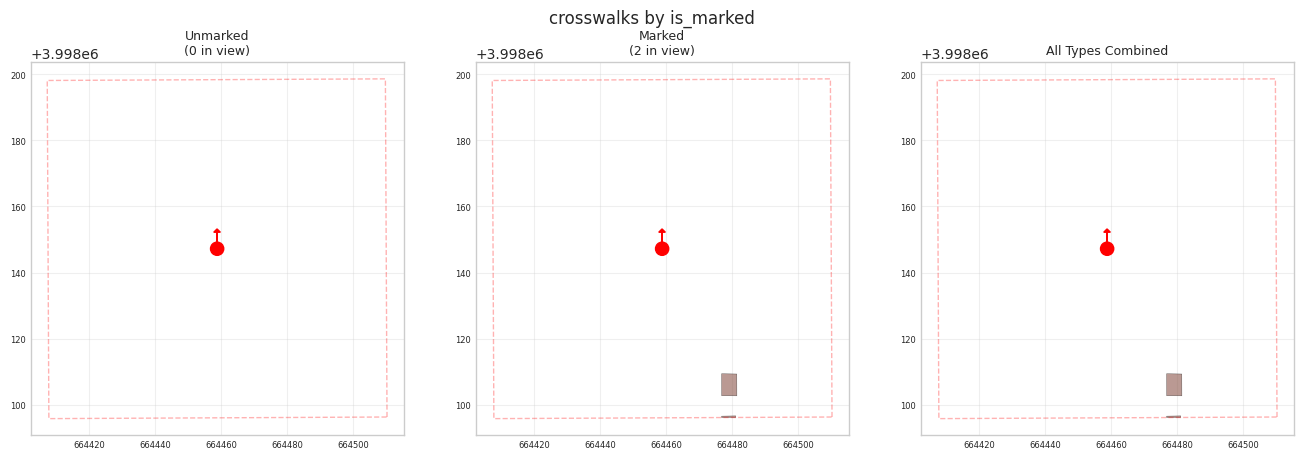


📊 lanes_polygons.lane_index


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


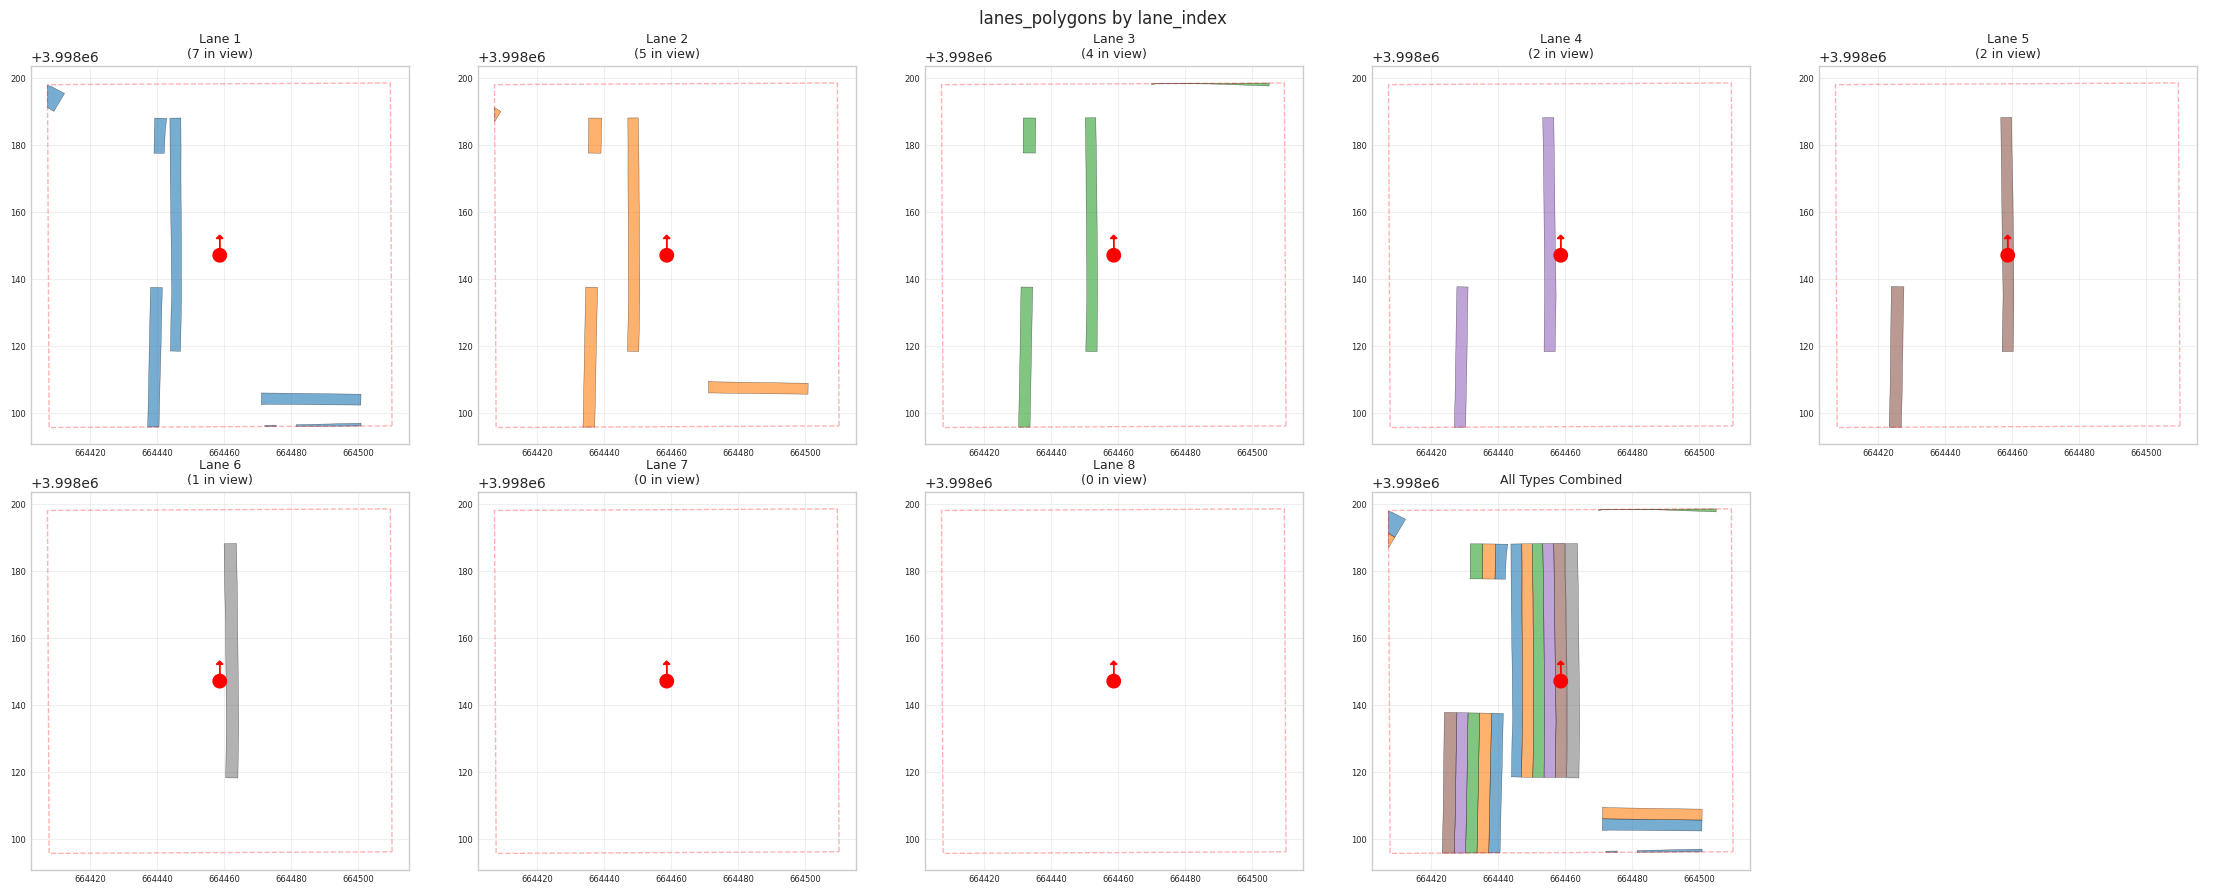


📊 stop_polygons.stop_polygon_type_fid


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


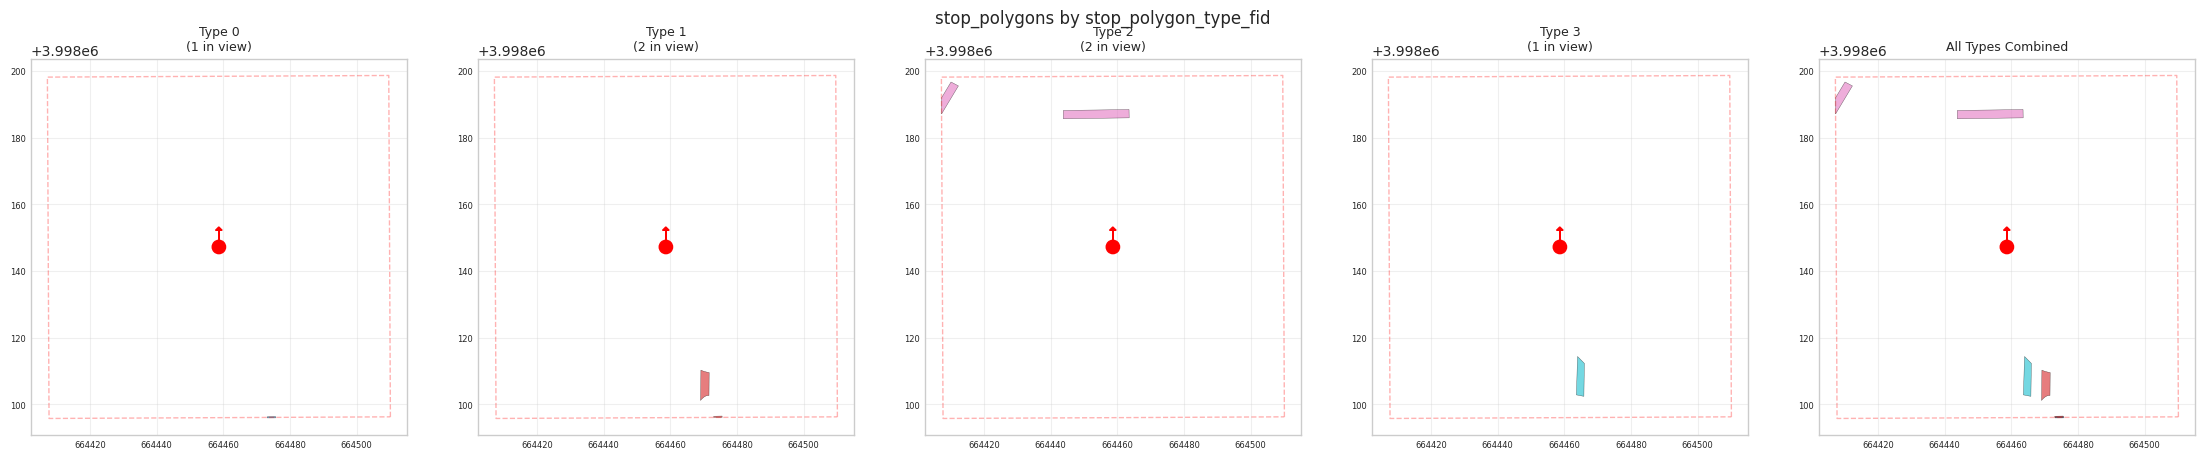


📊 traffic_lights.light_face_type_fid


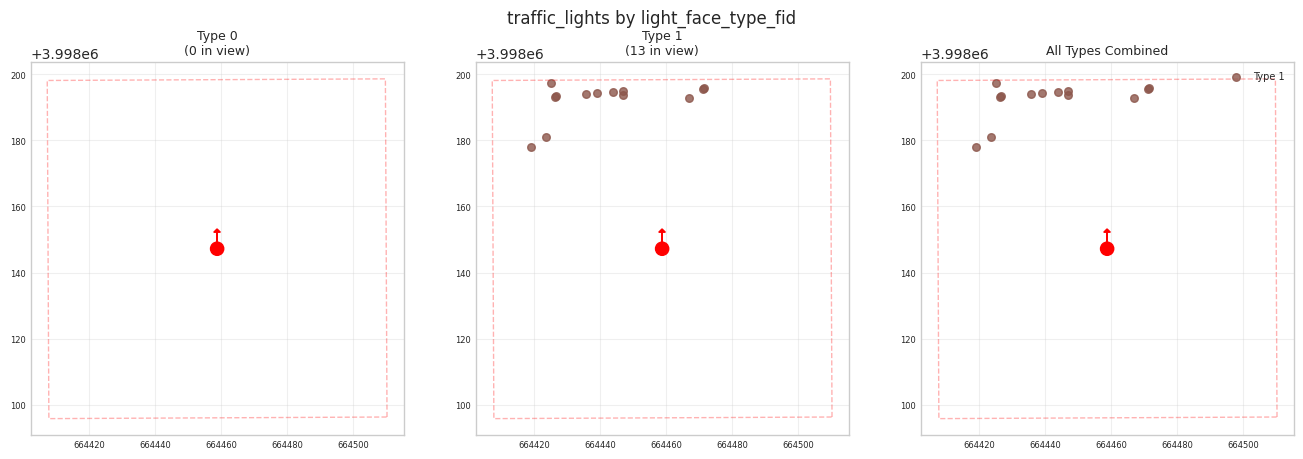


=== 시각화 완료 ===


In [40]:
# 의미있는 카테고리 컬럼들 전체 시각화
import matplotlib.cm as cm

# 시각화할 레이어-컬럼 목록
viz_targets = [
    ('baseline_paths', 'path_type_fid', {0: 'Type 0', 1: 'Type 1', 2: 'Type 2'}),
    ('lane_connectors', 'turn_type_fid', {0: 'Straight', 1: 'Left Turn', 2: 'Right Turn'}),
    ('lane_connectors', 'reflector_side_fid', {0: 'None', 1: 'Left', 2: 'Right', 3: 'Both'}),
    ('intersections', 'intersection_type_fid', {0: 'Type 0', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4', 5: 'Type 5'}),
    ('intersections', 'is_mini', {False: 'Normal', True: 'Mini'}),
    ('boundaries', 'boundary_type_fid', {0: 'Type 0', 2: 'Type 2 (Road)', 3: 'Type 3'}),
    ('crosswalks', 'is_marked', {False: 'Unmarked', True: 'Marked'}),
    ('lanes_polygons', 'lane_index', {i: f'Lane {i}' for i in range(1, 9)}),
    ('stop_polygons', 'stop_polygon_type_fid', {0: 'Type 0', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3'}),
    ('traffic_lights', 'light_face_type_fid', {0: 'Type 0', 1: 'Type 1'}),
]

def plot_layer_by_type(gdf, type_col, type_names, layer_name, view_box, ego_x, ego_y, cos_h, sin_h):
    """레이어를 타입별로 시각화"""
    unique_types = sorted(gdf[type_col].dropna().unique())
    n_types = len(unique_types)
    
    if n_types == 0:
        return
    
    # 색상 팔레트
    colors = cm.tab10(np.linspace(0, 1, max(n_types, 3)))
    type_colors = {t: colors[i] for i, t in enumerate(unique_types)}
    
    # subplot 구성
    cols = min(n_types + 1, 5)
    rows = (n_types + 1 + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows))
    if rows * cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    geom_type = gdf.geom_type.iloc[0]
    
    # 각 타입별 시각화
    for idx, t in enumerate(unique_types):
        ax = axes[idx]
        type_gdf = gdf[gdf[type_col] == t]
        clipped = type_gdf[type_gdf.geometry.intersects(view_box)].copy()
        
        if len(clipped) > 0:
            clipped['geometry'] = clipped.geometry.intersection(view_box)
            clipped = clipped[~clipped.geometry.is_empty]
            
            if geom_type == 'Point':
                x = [g.x for g in clipped.geometry if g and not g.is_empty]
                y = [g.y for g in clipped.geometry if g and not g.is_empty]
                ax.scatter(x, y, c=[type_colors[t]], s=30, alpha=0.8)
            elif geom_type == 'LineString':
                for geom in clipped.geometry:
                    if geom and not geom.is_empty:
                        if geom.geom_type == 'LineString':
                            ax.plot(*geom.xy, color=type_colors[t], linewidth=1.5, alpha=0.8)
                        elif geom.geom_type == 'MultiLineString':
                            for line in geom.geoms:
                                ax.plot(*line.xy, color=type_colors[t], linewidth=1.5, alpha=0.8)
            elif geom_type in ['Polygon', 'MultiPolygon']:
                clipped.plot(ax=ax, color=type_colors[t], edgecolor='black', linewidth=0.3, alpha=0.6)
        
        # Ego 표시
        ax.add_patch(plt.Circle((ego_x, ego_y), 2, color='red', zorder=10))
        ax.arrow(ego_x, ego_y, 5*cos_h, 5*sin_h, head_width=2, head_length=1, fc='red', ec='red', zorder=11)
        
        # View box
        ax.plot(*view_box.exterior.xy, 'r--', linewidth=1, alpha=0.3)
        ax.set_xlim(view_box.bounds[0]-5, view_box.bounds[2]+5)
        ax.set_ylim(view_box.bounds[1]-5, view_box.bounds[3]+5)
        ax.set_aspect('equal')
        ax.set_title(f'{type_names.get(t, f"Type {t}")}\n({len(clipped)} in view)', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=6)
    
    # 마지막: 전체 합쳐서 보기
    ax = axes[n_types] if n_types < len(axes) else axes[-1]
    for t in unique_types:
        type_gdf = gdf[gdf[type_col] == t]
        clipped = type_gdf[type_gdf.geometry.intersects(view_box)].copy()
        if len(clipped) > 0:
            clipped['geometry'] = clipped.geometry.intersection(view_box)
            clipped = clipped[~clipped.geometry.is_empty]
            
            if geom_type == 'Point':
                x = [g.x for g in clipped.geometry if g and not g.is_empty]
                y = [g.y for g in clipped.geometry if g and not g.is_empty]
                ax.scatter(x, y, c=[type_colors[t]], s=30, alpha=0.8, label=type_names.get(t, f'{t}'))
            elif geom_type == 'LineString':
                first = True
                for geom in clipped.geometry:
                    if geom and not geom.is_empty:
                        if geom.geom_type == 'LineString':
                            ax.plot(*geom.xy, color=type_colors[t], linewidth=1.5, alpha=0.8,
                                   label=type_names.get(t, f'{t}') if first else '')
                            first = False
                        elif geom.geom_type == 'MultiLineString':
                            for line in geom.geoms:
                                ax.plot(*line.xy, color=type_colors[t], linewidth=1.5, alpha=0.8,
                                       label=type_names.get(t, f'{t}') if first else '')
                                first = False
            elif geom_type in ['Polygon', 'MultiPolygon']:
                clipped.plot(ax=ax, color=type_colors[t], edgecolor='black', linewidth=0.3, alpha=0.6, label=type_names.get(t, f'{t}'))
    
    ax.add_patch(plt.Circle((ego_x, ego_y), 2, color='red', zorder=10))
    ax.arrow(ego_x, ego_y, 5*cos_h, 5*sin_h, head_width=2, head_length=1, fc='red', ec='red', zorder=11)
    ax.plot(*view_box.exterior.xy, 'r--', linewidth=1, alpha=0.3)
    ax.set_xlim(view_box.bounds[0]-5, view_box.bounds[2]+5)
    ax.set_ylim(view_box.bounds[1]-5, view_box.bounds[3]+5)
    ax.set_aspect('equal')
    ax.set_title('All Types Combined', fontsize=9)
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=6)
    
    # 빈 subplot 숨기기
    for idx in range(n_types + 1, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{layer_name} by {type_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

# 모든 타겟 시각화
print("="*60)
print("=== 모든 카테고리 컬럼 타입별 시각화 ===")
print("="*60)

for layer_name, type_col, type_names in viz_targets:
    if layer_name not in sample_layers_utm:
        print(f"\n⚠️ {layer_name} 레이어 없음")
        continue
    
    gdf = sample_layers_utm[layer_name]
    if type_col not in gdf.columns:
        print(f"\n⚠️ {layer_name}.{type_col} 컬럼 없음")
        continue
    
    print(f"\n📊 {layer_name}.{type_col}")
    plot_layer_by_type(gdf, type_col, type_names, layer_name, view_box, ego_x_global, ego_y_global, cos_h, sin_h)

print("\n" + "="*60)
print("=== 시각화 완료 ===")
print("="*60)